In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from sklearn.metrics import make_scorer, mean_squared_error,mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [2]:
features_col = ['Arflux','Fflux',
            'ArExponent','FrExponent',
            'yield_at_zero1','yield_at_zero2','yield_at_zero3',
            'yield_max1','yield_max2','yield_max3',
            'theta_max1','theta_max2','theta_max3','mizk',
            'p1','p2','p3','p4','p5']

In [3]:
def get_time(filename):
    values = filename.split("_")
    for t_value in values:
        if t_value in ['2','4','6','8','10','12']:
            return int(t_value)
    return None

In [4]:
def get_total():
    total = 0
    for file in sorted(os.listdir(f'C:/Users/jayra/OneDrive/Documents/IITGN/Sentaurus/Data_with_constant_flux/csvfiles'), key=len):
        total+=len(os.listdir(f'C:/Users/jayra/OneDrive/Documents/IITGN/Sentaurus/Data_with_constant_flux/csvfiles/{file}')) 
    return total

In [5]:
df_final = pd.DataFrame()
# valid_df_final = pd.DataFrame()
test_df_final = pd.DataFrame()

test_file_num = 0
turn = 1

total  = get_total()

test_size = int(0.2*total)

for folder in sorted(os.listdir(f'C:/Users/jayra/OneDrive/Documents/IITGN/Sentaurus/Data_with_constant_flux/csvfiles'), key=len):

    # sorting file acc to len so that t= 10,12 gets to its original pos
    for file in sorted(os.listdir(f'C:/Users/jayra/OneDrive/Documents/IITGN/Sentaurus/Data_with_constant_flux/csvfiles/{folder}'), key=len):

        input_values = file.split('_')[1:-3]
        input_values = [float(item) for item in input_values]
        if(turn <= 8):
            df = pd.read_csv(f'C:/Users/jayra/OneDrive/Documents/IITGN/Sentaurus/Data_with_constant_flux/csvfiles/{folder}/{file}')

        #dropping rows with zero valies in it
            zero_values_row_index = df[df['FitRadius_Avg']==0].index
            df = df.drop(zero_values_row_index)
            indexes_of_not_silicon = df[df['Z']>=0.000].index
            df = df.drop(indexes_of_not_silicon)

            df['Z'] = df['Z'].apply(lambda x: round(x,7))

            new_df = pd.DataFrame()

            new_df['Z'] = df['Z'][::5]
            new_df['avg fitradius'] = df['FitRadius_Avg'][::5]
            new_df['time'] = get_time(file)

            for i in range(len(input_values)):
                    # print(features_col[i], input_values[i])
                new_df[features_col[i]] = input_values[i]
            df_final = pd.concat([df_final,new_df])   
            turn+=1

        else:
            test_file_num+=1

            test_df = pd.read_csv(f'C:/Users/jayra/OneDrive/Documents/IITGN/Sentaurus/Data_with_constant_flux/csvfiles/{folder}/{file}')

            #dropping rows with zero valies in it
            zero_values_row_index = test_df[test_df['FitRadius_Avg']==0].index
            test_df = test_df.drop(zero_values_row_index)
            indexes_of_not_silicon = test_df[test_df['Z']>=0.000].index
            test_df = test_df.drop(indexes_of_not_silicon)

            test_df['Z'] = test_df['Z'].apply(lambda x: round(x,7))

            new_df = pd.DataFrame()

            new_df['Z'] = test_df['Z'].iloc[::5]
            new_df['avg fitradius'] = test_df['FitRadius_Avg'][::5]
            new_df['time'] = get_time(file)

            for i in range(len(input_values)):
                    # print(features_col[i], input_values[i])
                new_df[features_col[i]] = input_values[i]
            test_df_final = pd.concat([test_df_final,new_df])    

            if turn==9: turn+=1
            else: turn = 1

In [6]:
test_df_final.shape

(59838, 22)

<Axes: >

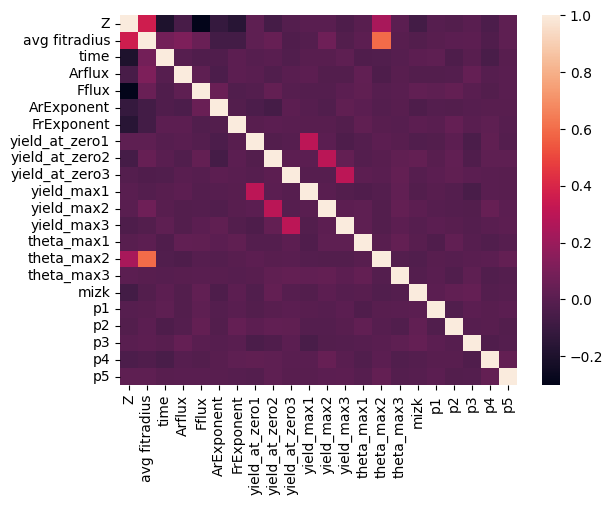

In [7]:
sns.heatmap(df_final.corr())

In [8]:
def relative_mean_absolute_error(y_true, y_pred):
    
    # Convert inputs to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate Mean Absolute Error (MAE)
    rmae = np.mean((np.abs(y_true - y_pred))/y_true)
    
    return rmae

def custom_mse(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def custom_r2(y_true, y_pred):
    return r2_score(y_true, y_pred)

In [9]:
x_train = df_final.loc[:, ~df_final.columns.isin(['avg fitradius'])] #removing time as well right now
y_train = df_final[['avg fitradius']]

y_test = test_df_final[['avg fitradius']]
x_test = test_df_final.drop(['avg fitradius'], axis=1)

In [10]:
from sklearn.preprocessing import StandardScaler

scaler_x_train = StandardScaler()
X_scale_arr = scaler_x_train.fit_transform(x_train)
df_scaledX = pd.DataFrame(X_scale_arr, columns=x_train.columns)

scaler_y_train = StandardScaler()
y_scale_arr = scaler_y_train.fit_transform(y_train)
df_scaledy = pd.DataFrame(y_scale_arr, columns=y_train.columns)

scaler_x_test = StandardScaler()
X_scale_t_arr = scaler_x_test.fit_transform(x_test)
df_scaledX_t = pd.DataFrame(X_scale_t_arr, columns=x_test.columns)

scaler_y_test = StandardScaler()
y_scale_t_arr = scaler_y_test.fit_transform(y_test)
df_scaledy_t = pd.DataFrame(y_scale_t_arr, columns=y_test.columns)


X_train_scaled_reshaped = X_scale_arr.reshape(X_scale_arr.shape[0],1,X_scale_arr.shape[1])
X_train_scaled_reshaped.shape

X_test_scaled_reshaped = X_scale_t_arr.reshape(X_scale_t_arr.shape[0],1,X_scale_t_arr.shape[1])
X_test_scaled_reshaped.shape

(59838, 1, 21)

In [12]:
y_train_scale = y_train*1000000
y_test_scale = y_test*1000000

In [13]:
indexes = []
curr_Arflux = x_test['Arflux'].to_list()[0]
counter = 0
for  index, row in x_test.iterrows():
    if(row['Arflux']!=curr_Arflux):
        indexes.append(counter)
        curr_Arflux = row['Arflux']
    counter+=1

In [85]:
#LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from keras.callbacks import EarlyStopping


def create_lstm_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(512, return_sequences=True, activation='relu'))
    model.add(LSTM(256, return_sequences=True, activation='relu'))
    model.add(LSTM(128, return_sequences=True, activation='relu'))
    model.add(LSTM(64, activation='relu'))
    model.add(Dense(1))  # Assuming 2 target variables
    model.compile(optimizer='adam', loss='mape')
    return model

model = create_lstm_model(input_shape=(X_train_scaled_reshaped.shape[1], X_train_scaled_reshaped.shape[2]))
early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0001, verbose=1)
# model.load_weights('model_2l_lstm_intermediate.weights.h5')
history = model.fit(X_train_scaled_reshaped, y_train_scale, epochs=50, batch_size=256, verbose=1, validation_data=(X_test_scaled_reshaped, y_test_scale), 
                    callbacks=[early_stopping]
                    )

# Predict on the test set
y_pred = model.predict(X_test_scaled_reshaped)
print(f'Loss: {relative_mean_absolute_error(y_test_scale, y_pred)}')
# model.save_weights('model_2l_lstm_intermediate.weights.h5')

Epoch 1/50
957/957 ━━━━━━━━━━━━━━━━━━━━ 51s 47ms/step - loss: 62.6123 - val_loss: 30.4512
Epoch 2/50
957/957 ━━━━━━━━━━━━━━━━━━━━ 56s 59ms/step - loss: 26.4445 - val_loss: 21.6093
Epoch 3/50
957/957 ━━━━━━━━━━━━━━━━━━━━ 52s 55ms/step - loss: 18.2009 - val_loss: 17.9247
Epoch 4/50
957/957 ━━━━━━━━━━━━━━━━━━━━ 53s 55ms/step - loss: 15.1850 - val_loss: 15.8710
Epoch 5/50
957/957 ━━━━━━━━━━━━━━━━━━━━ 51s 54ms/step - loss: 13.4516 - val_loss: 14.7077
Epoch 6/50
957/957 ━━━━━━━━━━━━━━━━━━━━ 52s 54ms/step - loss: 12.0999 - val_loss: 13.8906
Epoch 7/50
957/957 ━━━━━━━━━━━━━━━━━━━━ 52s 55ms/step - loss: 11.3038 - val_loss: 13.1344
Epoch 8/50
957/957 ━━━━━━━━━━━━━━━━━━━━ 53s 56ms/step - loss: 10.2733 - val_loss: 12.8953
Epoch 9/50
957/957 ━━━━━━━━━━━━━━━━━━━━ 52s 55ms/step - loss: 9.5805 - val_loss: 12.1998
Epoch 10/50
957/957 ━━━━━━━━━━━━━━━━━━━━ 52s 54ms/step - loss: 9.1732 - val_loss: 12.3033
Epoch 11/50
957/957 ━━━━━━━━━━━━━━━━━━━━ 56s 59ms/step - loss: 8.8735 - val_loss: 11.5334
Epoch 12/50

KeyboardInterrupt: 

In [117]:
model.save_weights('model_2l_lstm_intermediate.weights.h5')

In [143]:
model = create_lstm_model(input_shape=(X_train_scaled_reshaped.shape[1], X_train_scaled_reshaped.shape[2]))
model.load_weights('model_2l_lstm_intermediate.weights.h5')
# Predict on the test set
y_pred = model.predict(X_test_scaled_reshaped)
print(f'Loss: {relative_mean_absolute_error(y_test_scale, y_pred)}')

C:\Users\jayra\AppData\Roaming\Python\Python311\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1870/1870 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step
Loss: 0.08781509788541662


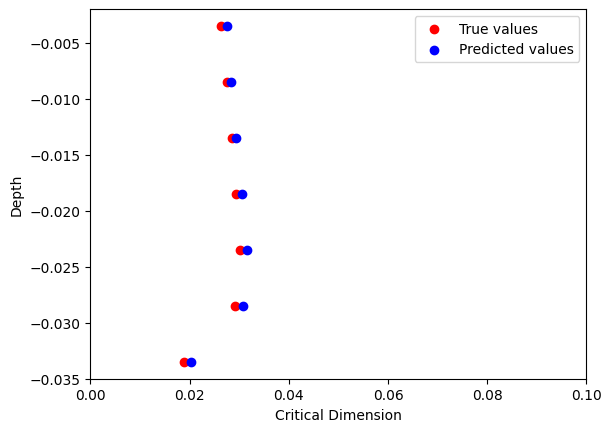

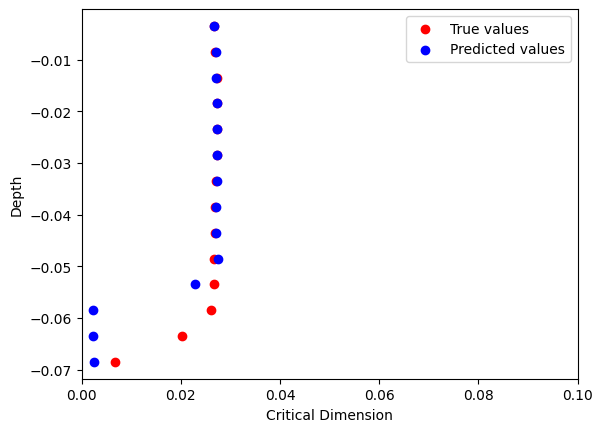

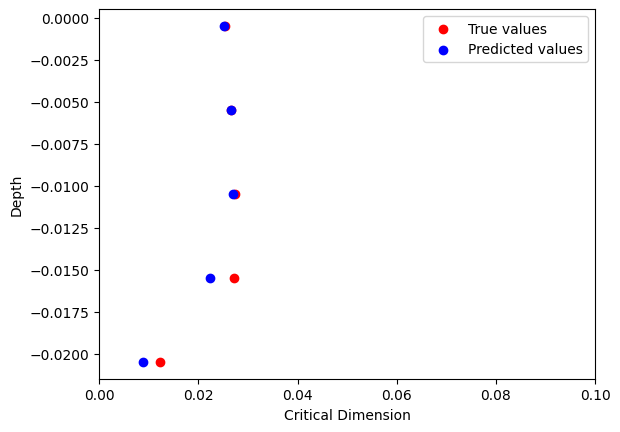

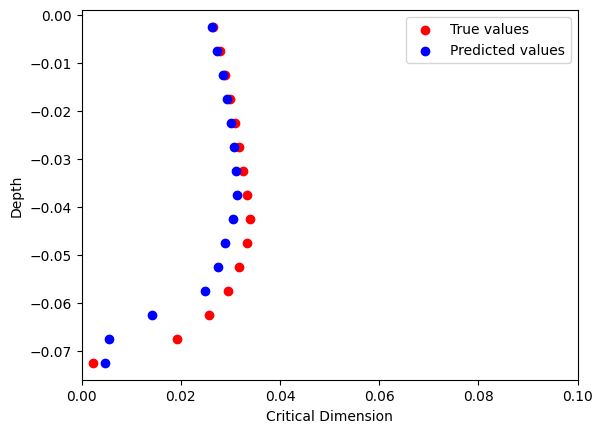

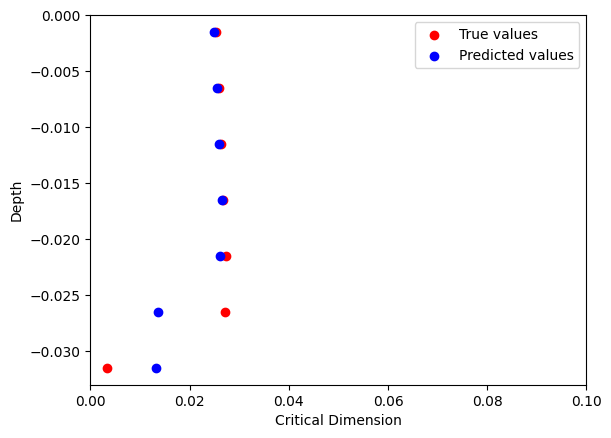

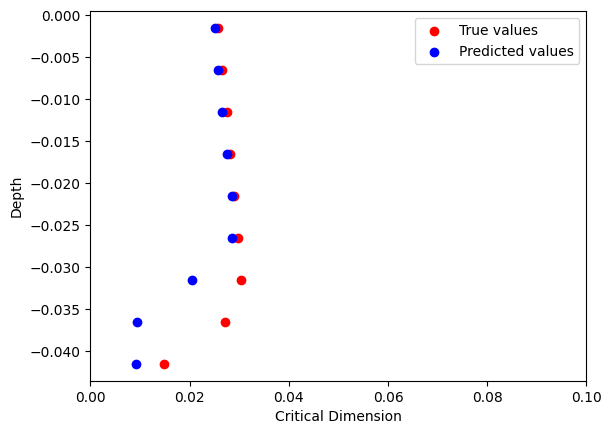

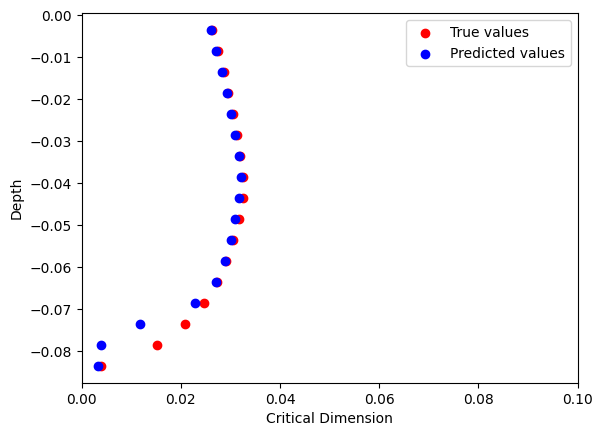

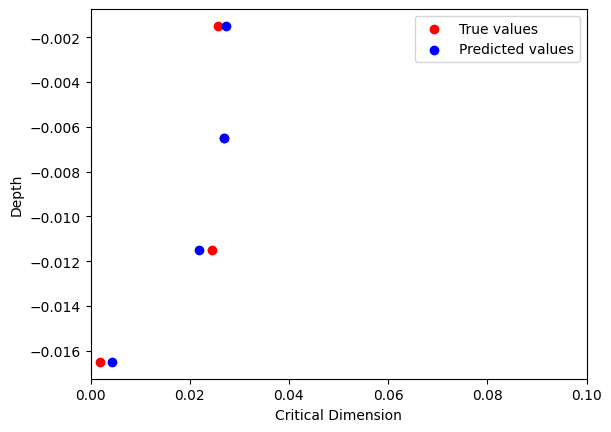

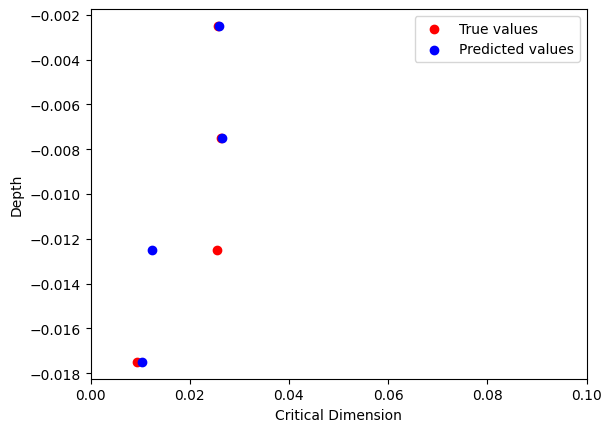

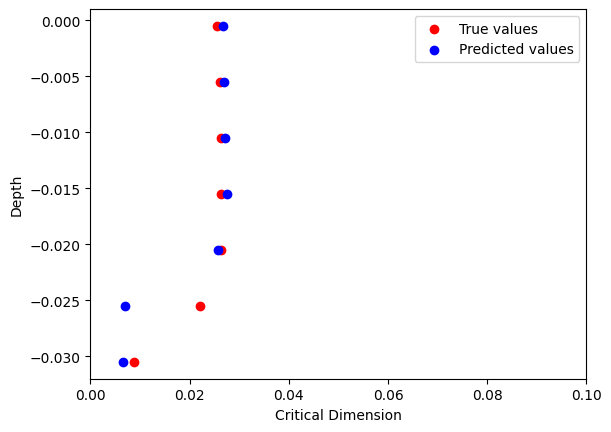

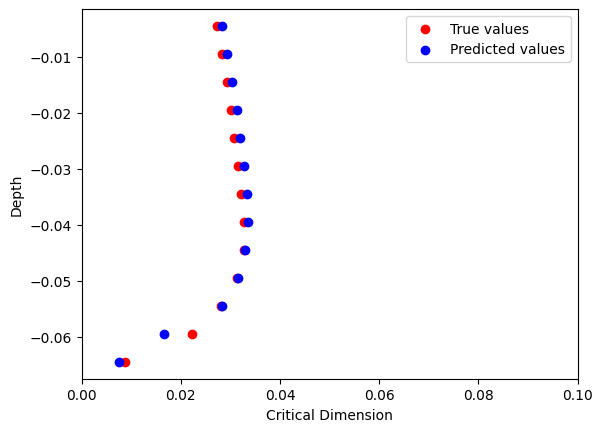

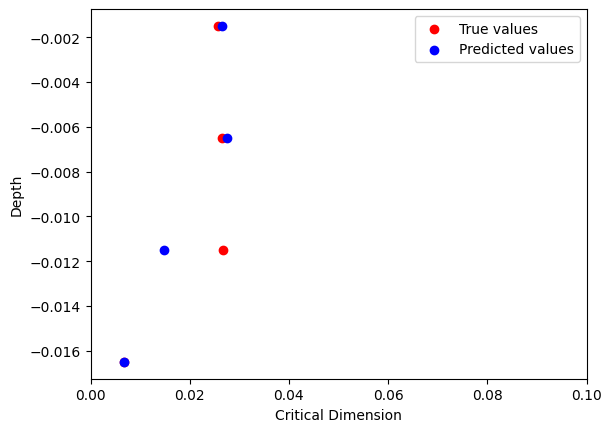

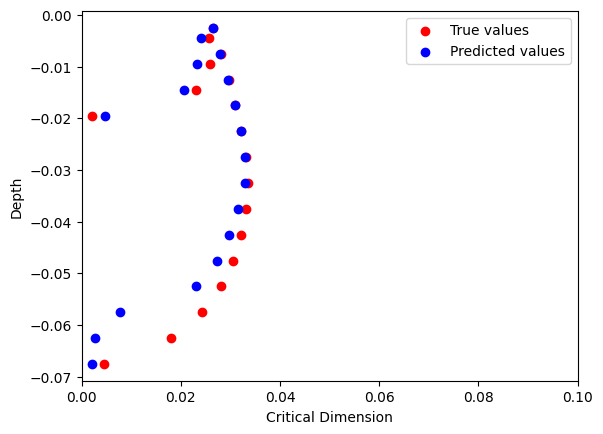

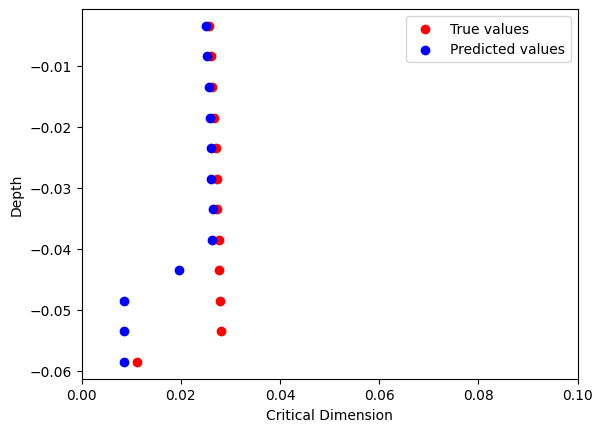

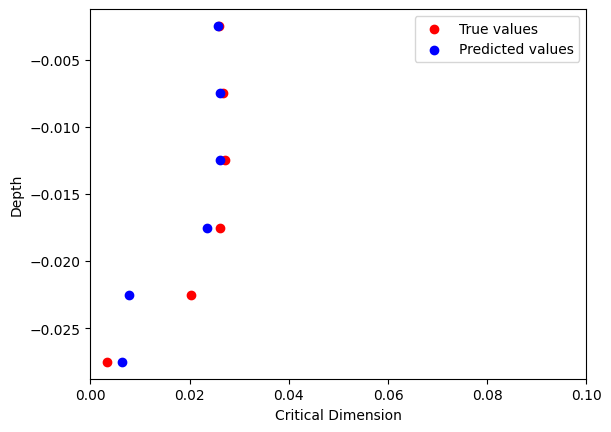

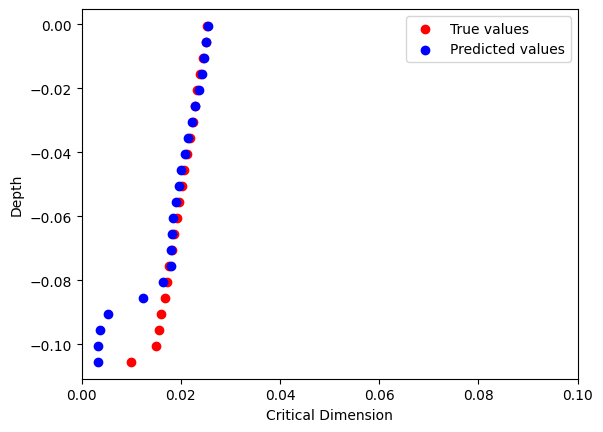

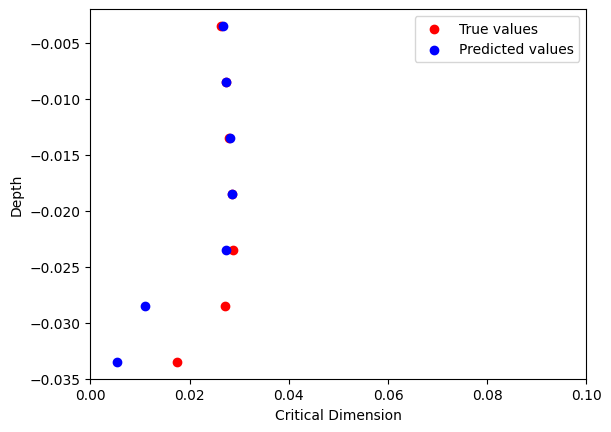

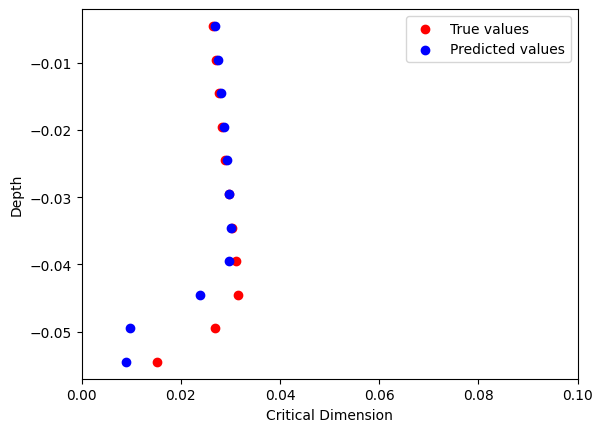

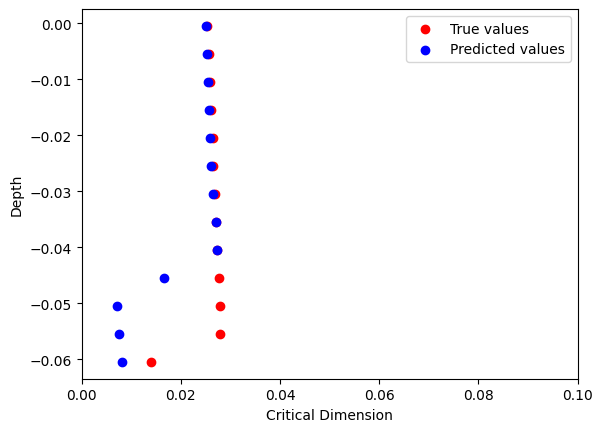

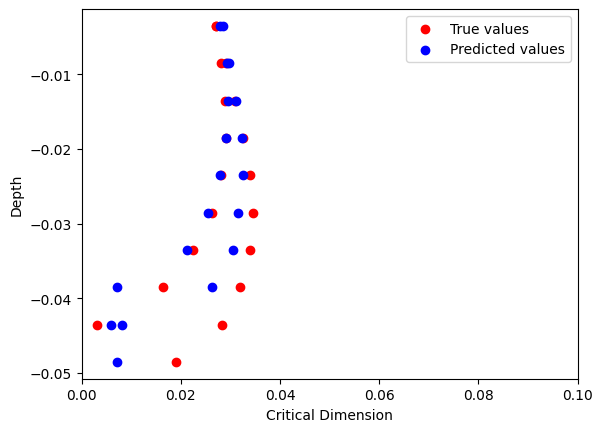

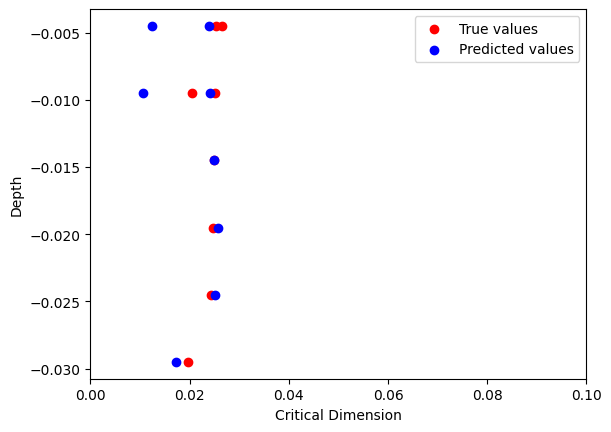

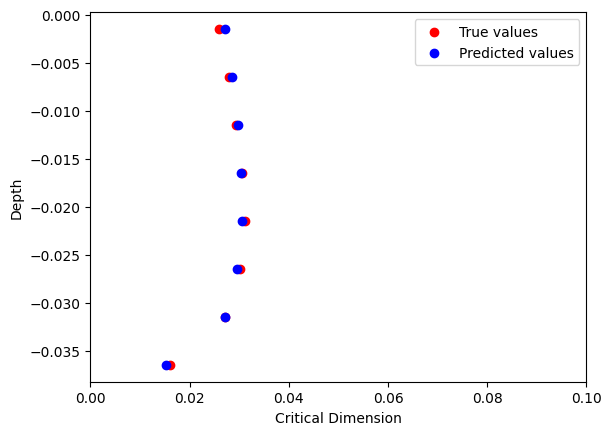

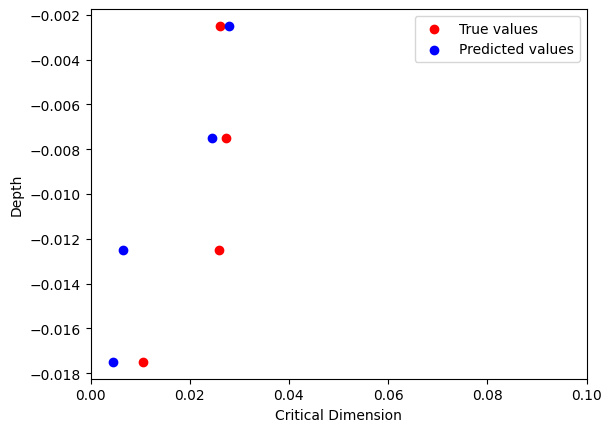

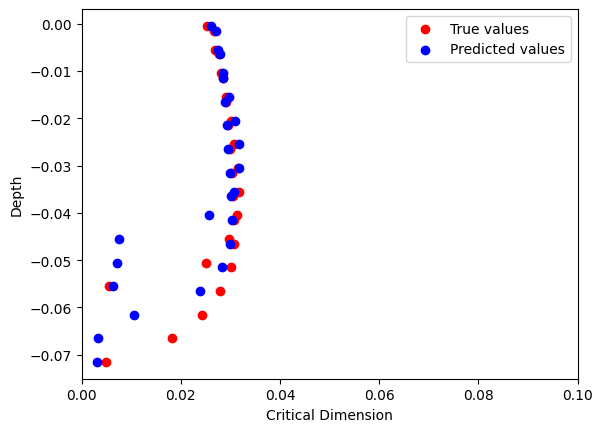

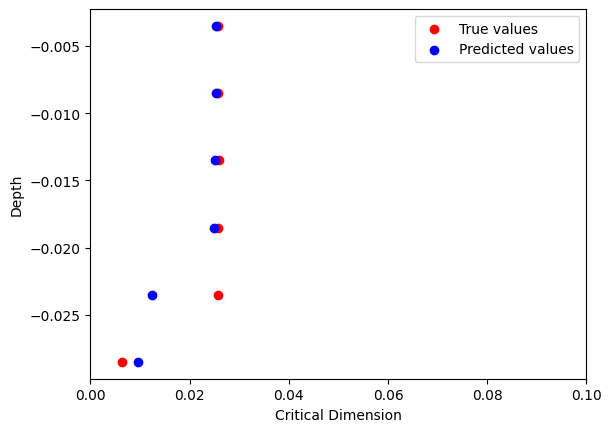

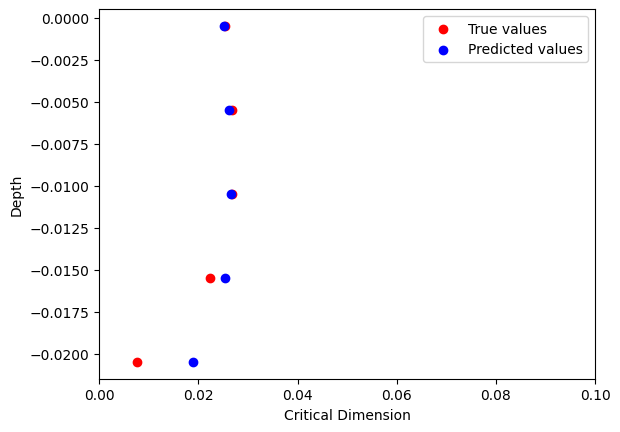

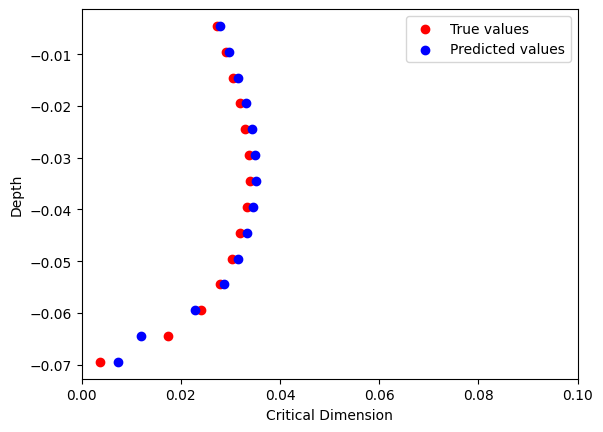

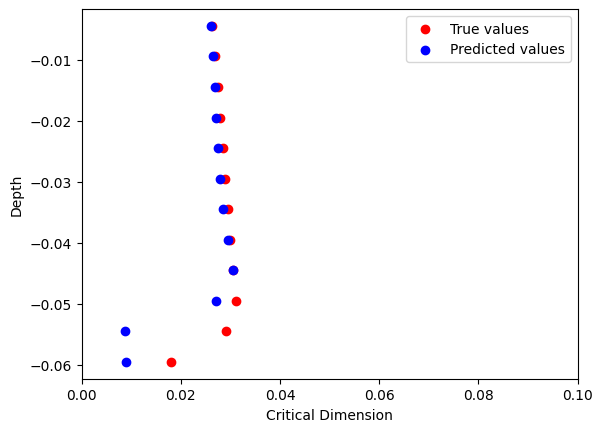

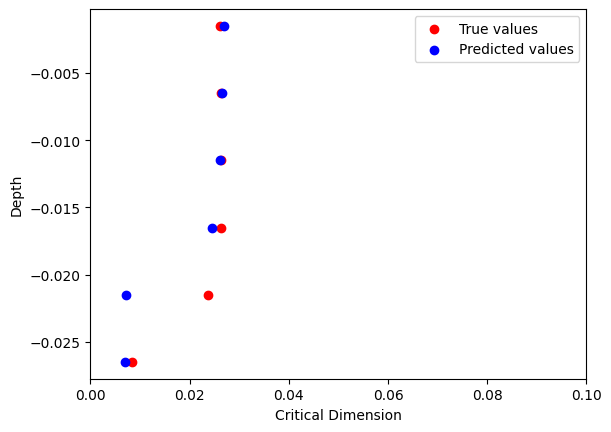

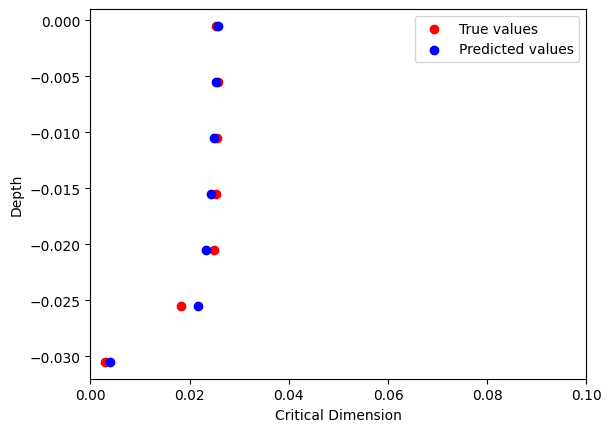

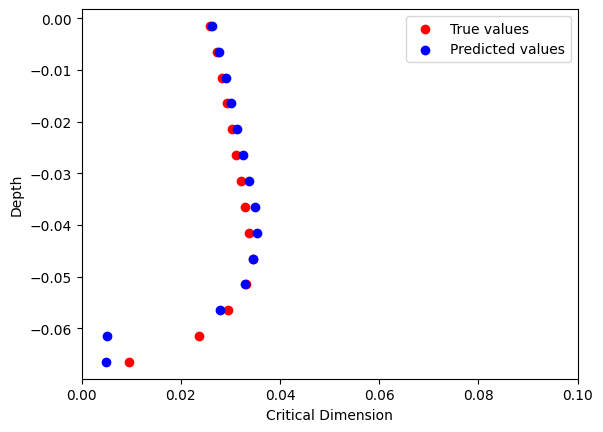

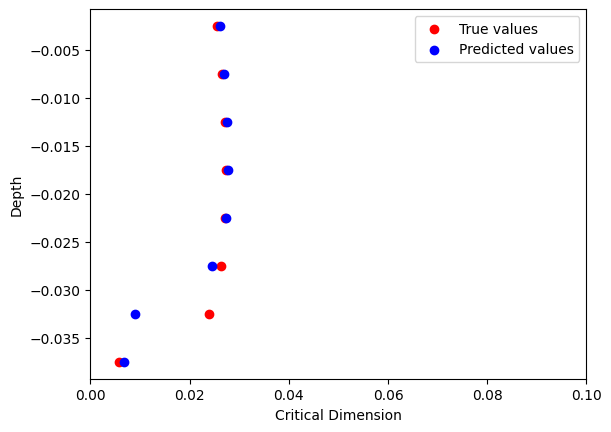

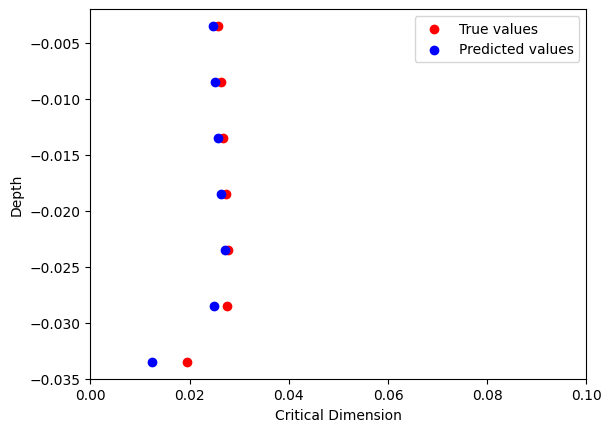

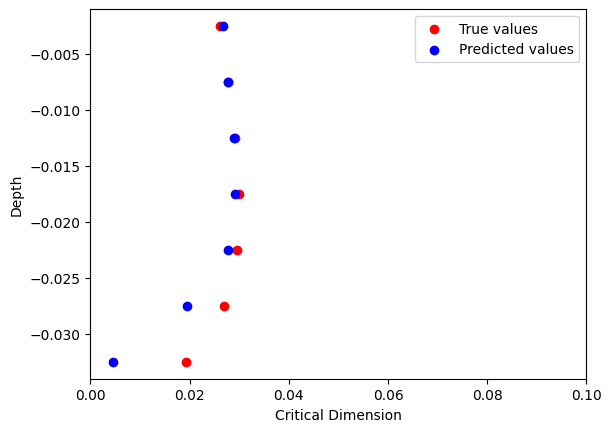

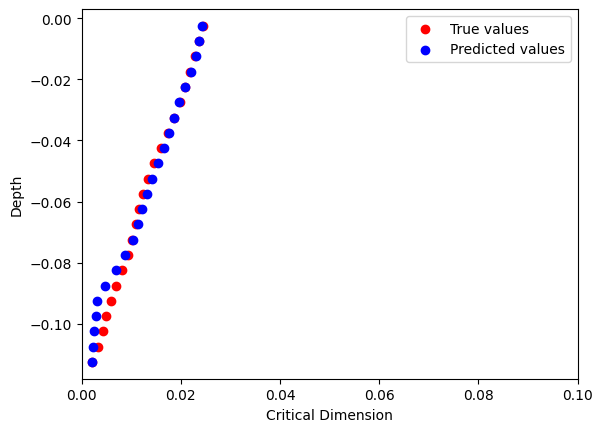

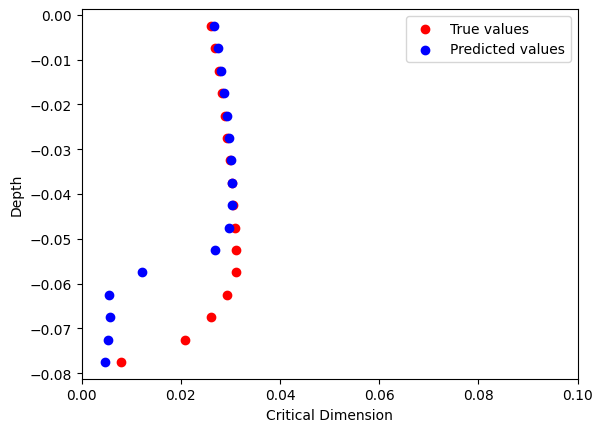

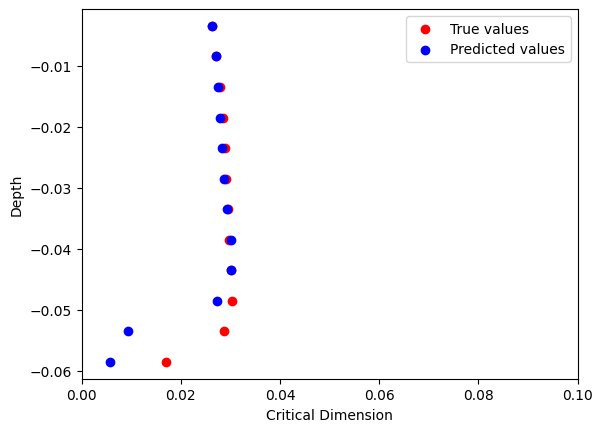

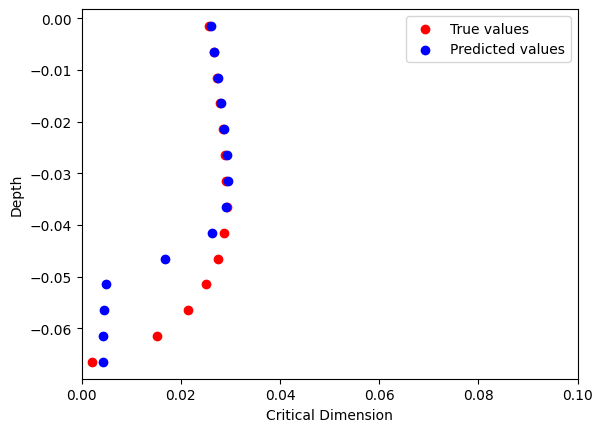

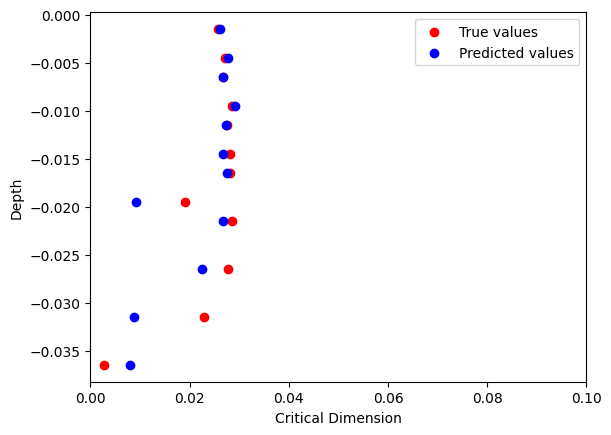

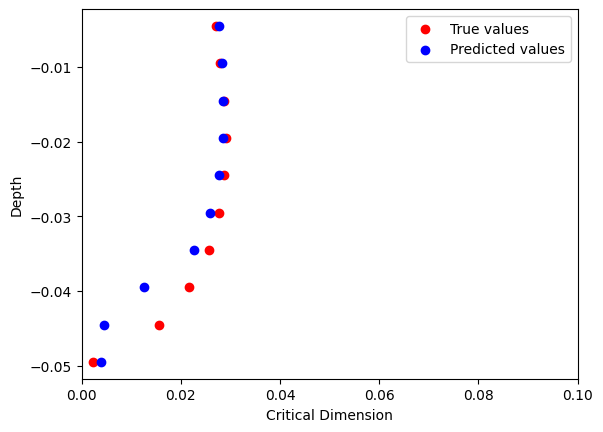

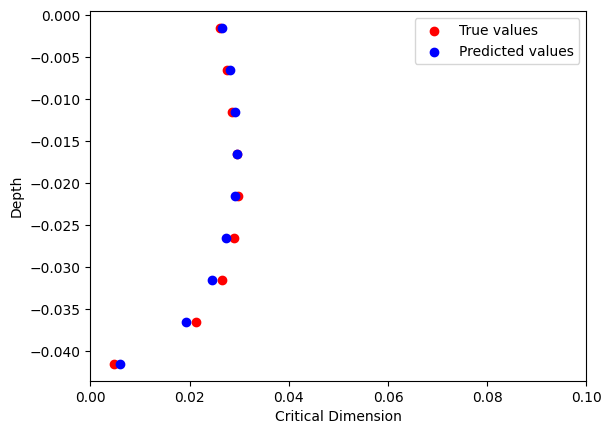

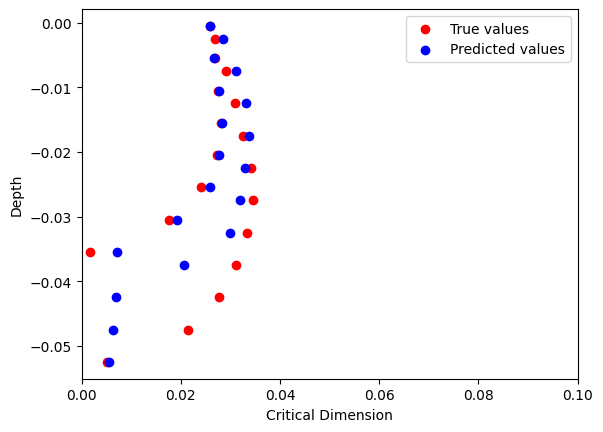

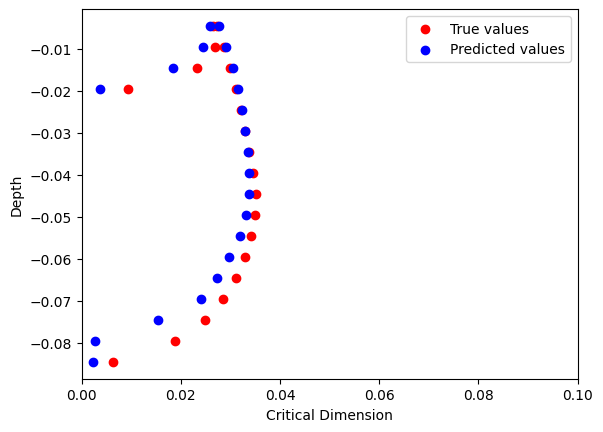

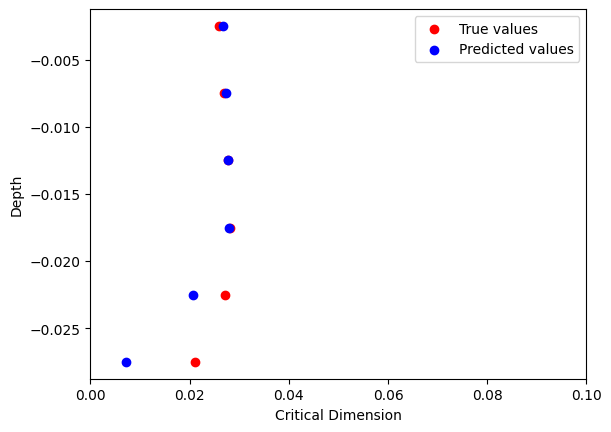

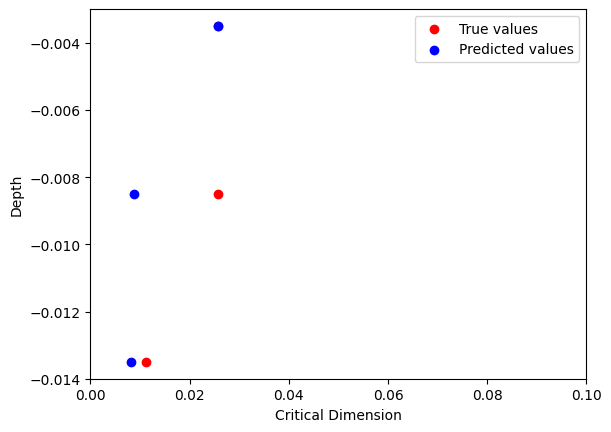

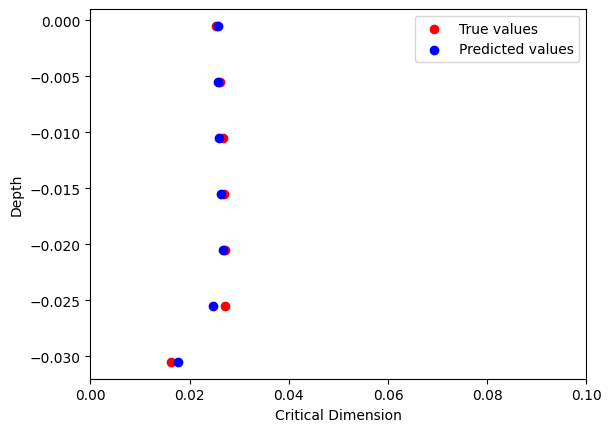

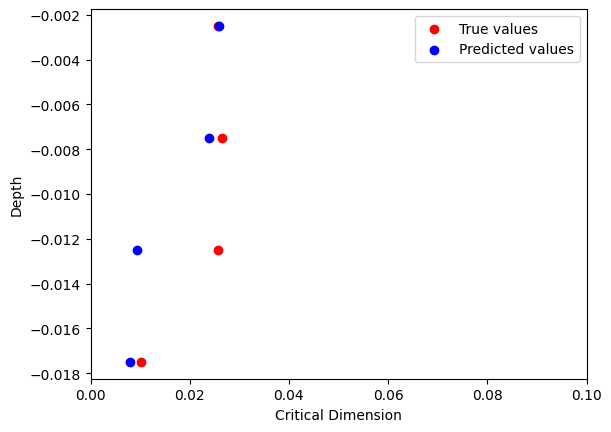

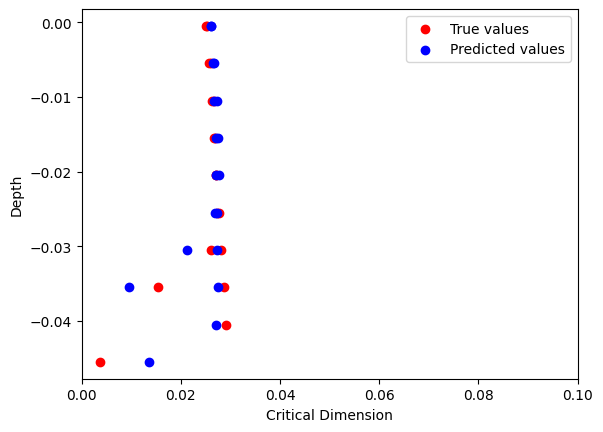

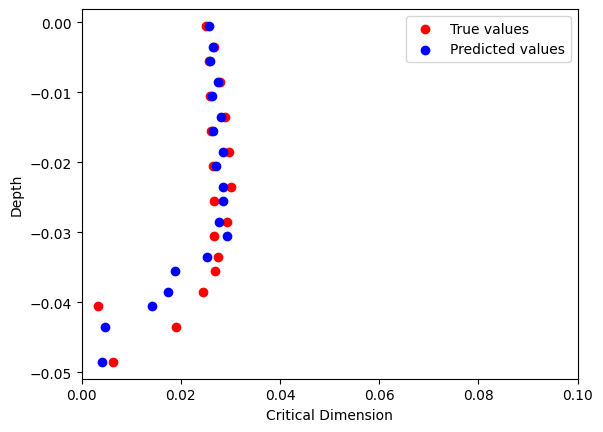

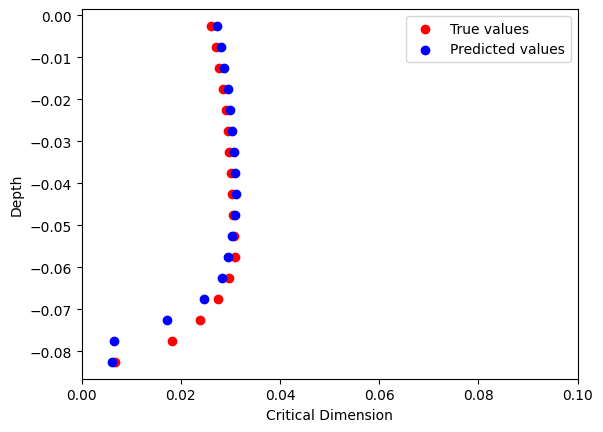

In [145]:
index = 0
count = 1
for i in indexes:
    plt.figure()
    plt.xlim(0,0.1)
    plt.ylabel('Depth')
    plt.xlabel('Critical Dimension')
    plt.scatter(y_test.iloc[index:i,0],x_test.iloc[index:i,0], c='red',label=f'True values')
    plt.scatter(y_pred[index:i,0]/1000000,x_test.iloc[index:i,0],c='blue',label=f'Predicted values')
    plt.legend()
    plt.show()
    index = i
    if count==50: break
    count+=1

For t = 12, reversing indexes

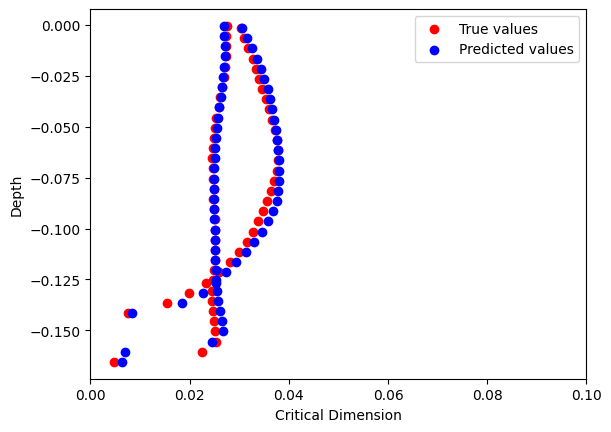

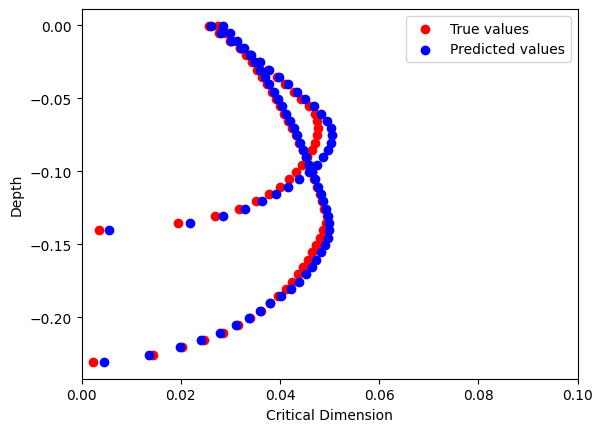

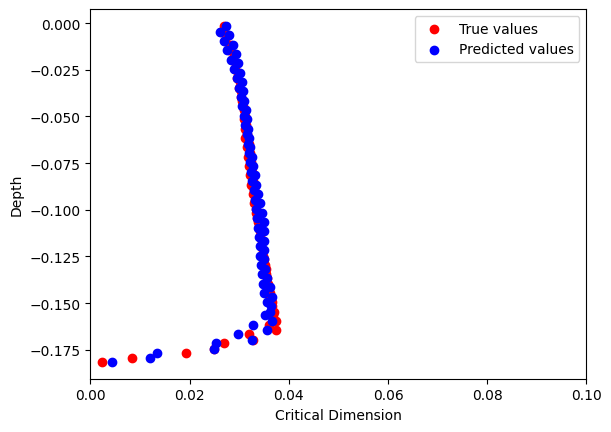

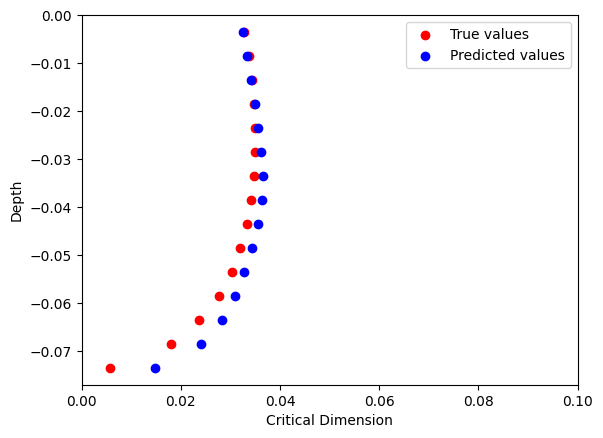

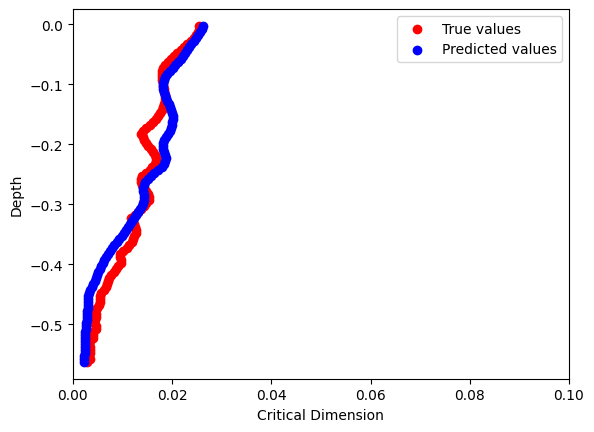

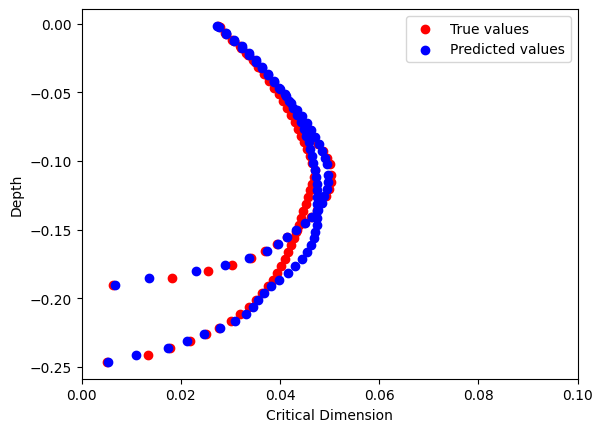

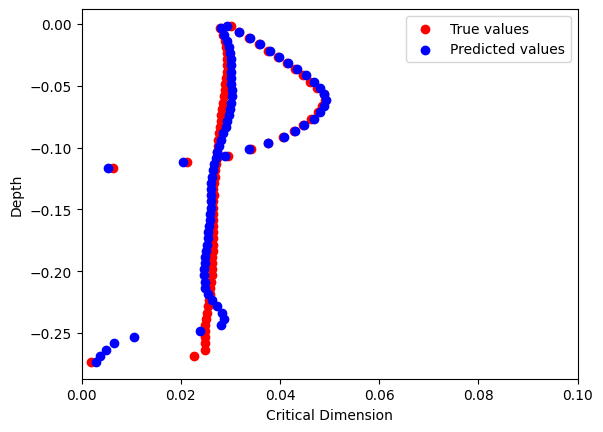

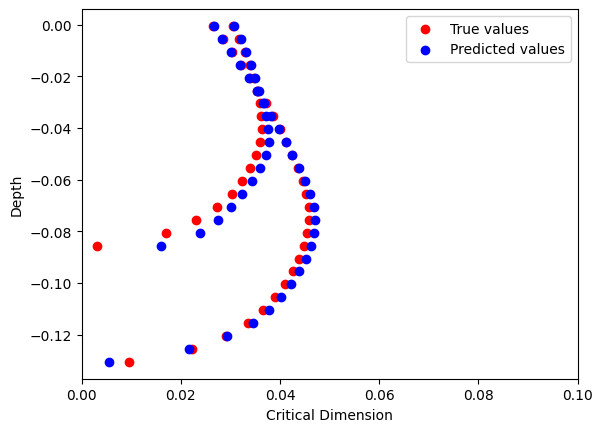

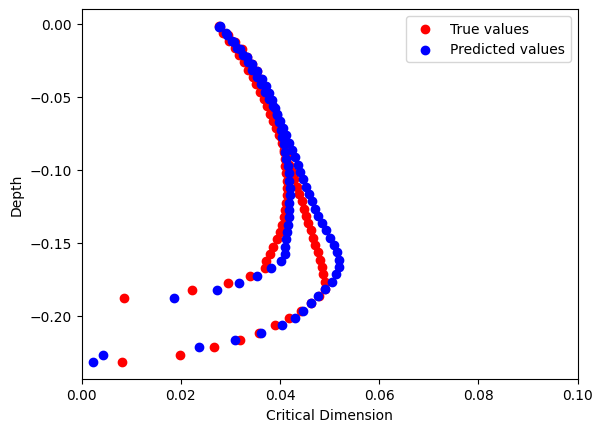

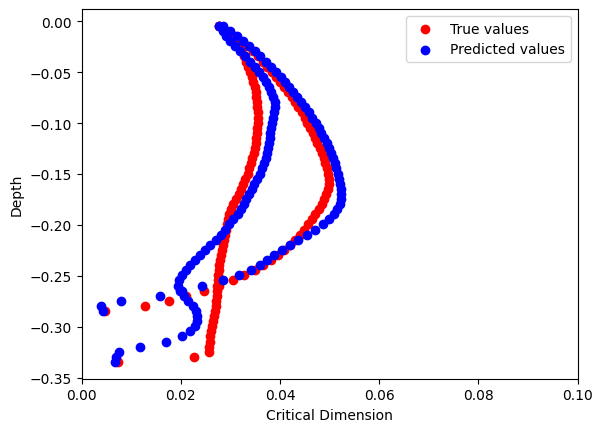

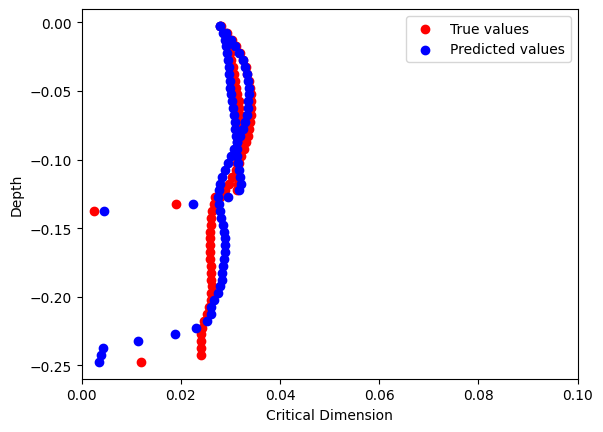

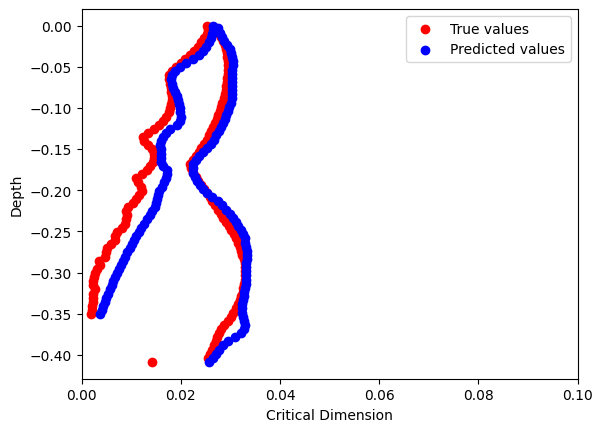

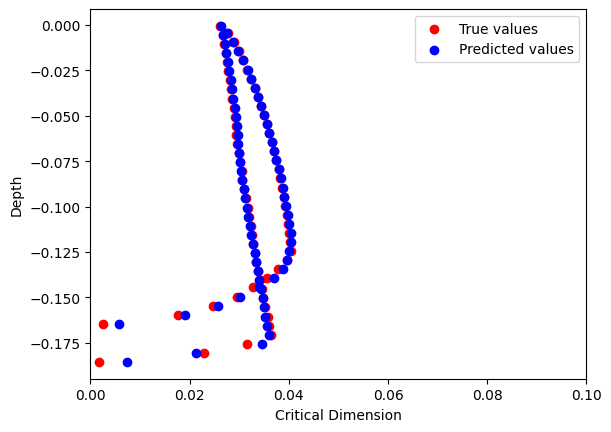

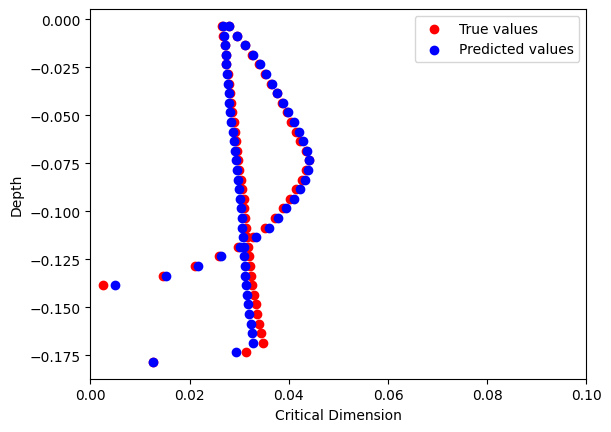

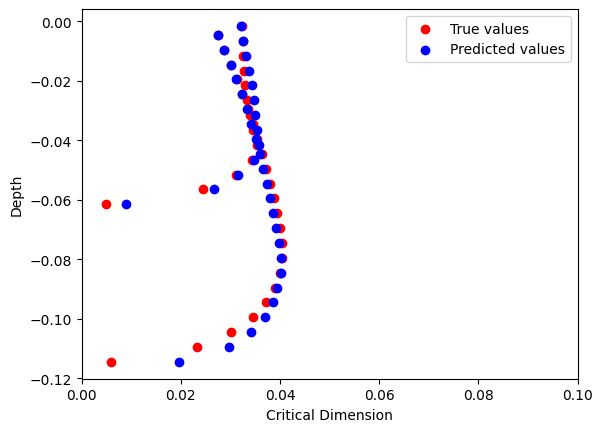

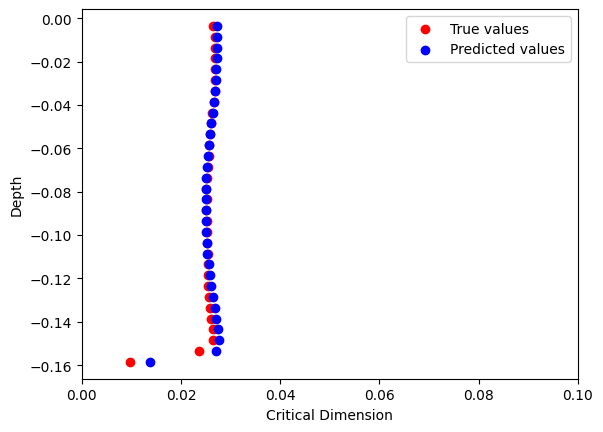

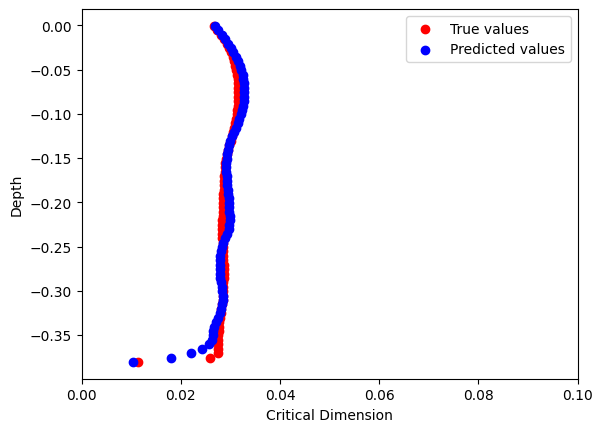

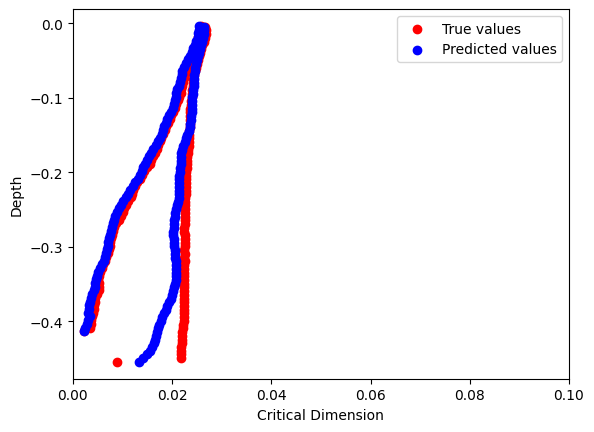

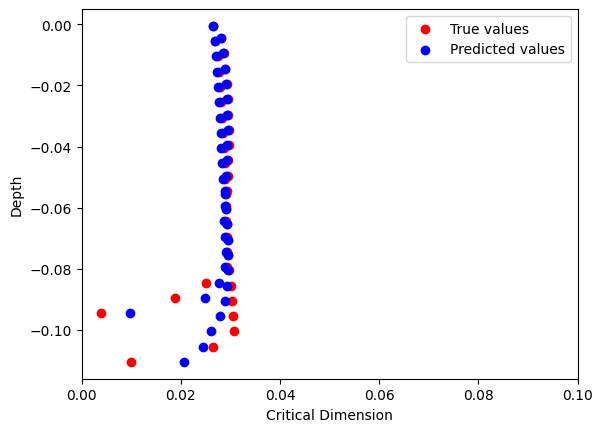

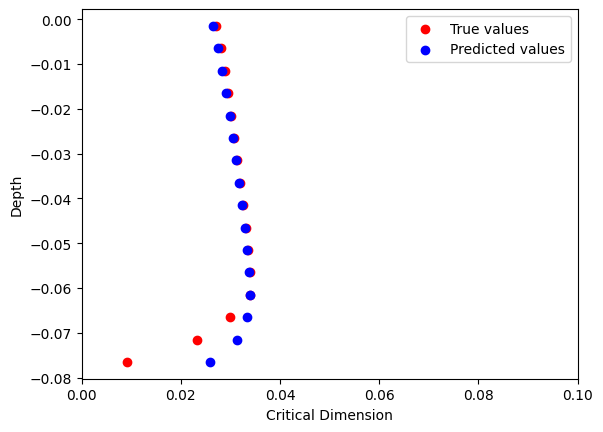

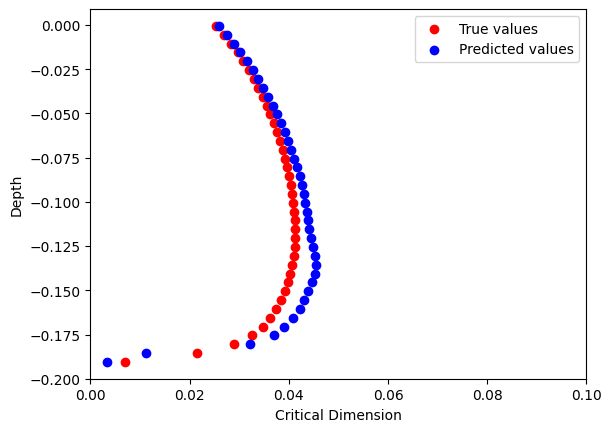

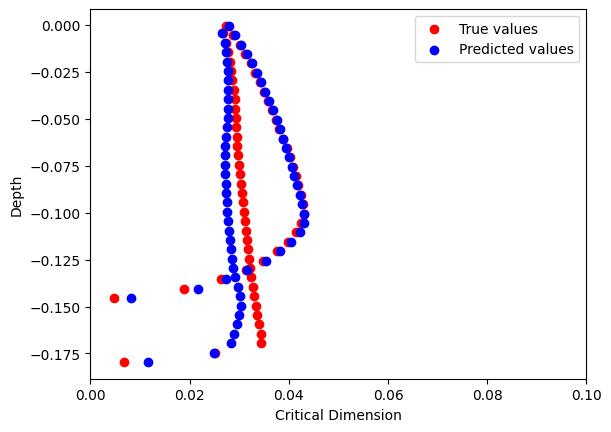

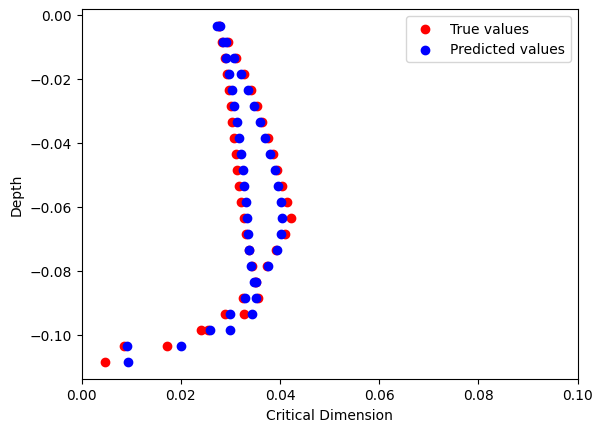

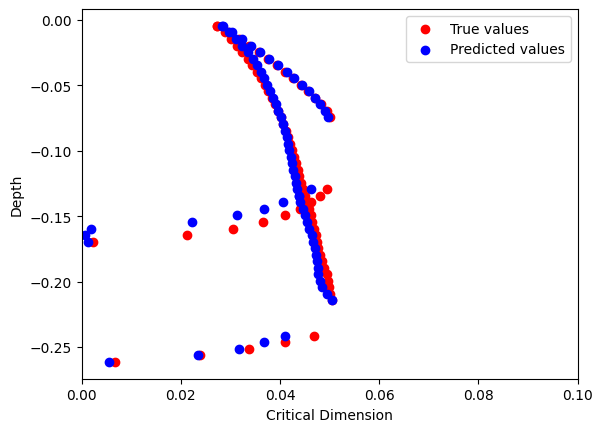

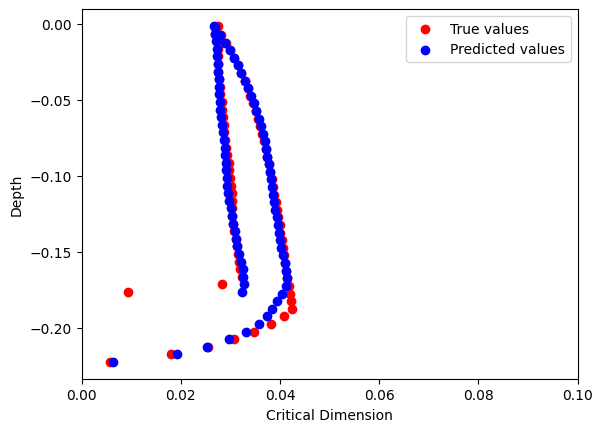

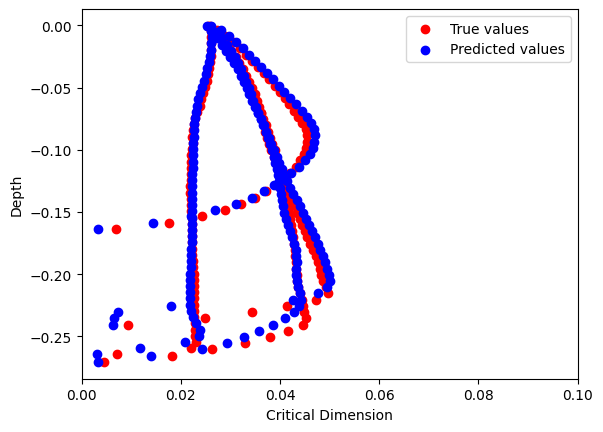

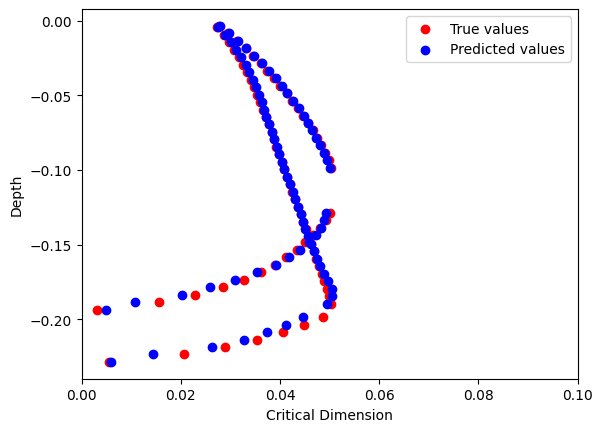

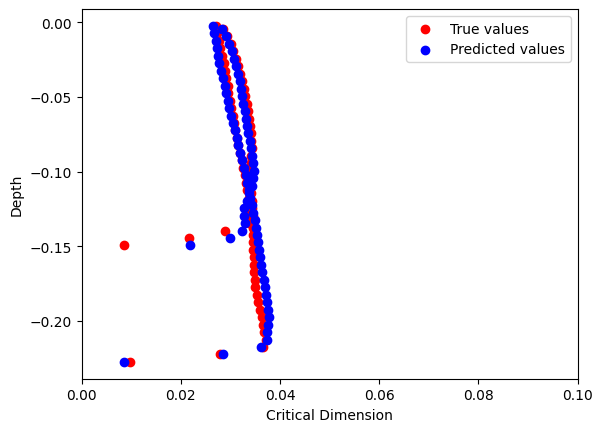

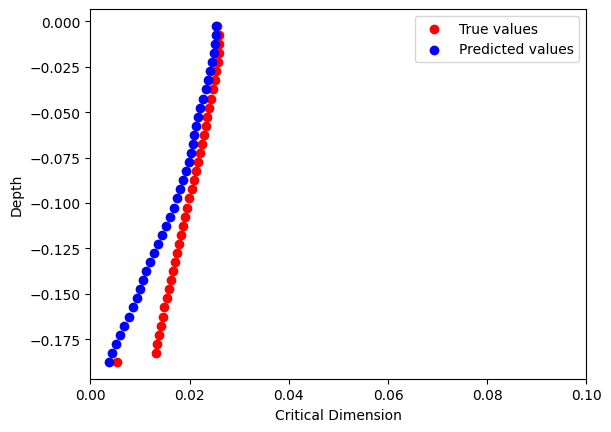

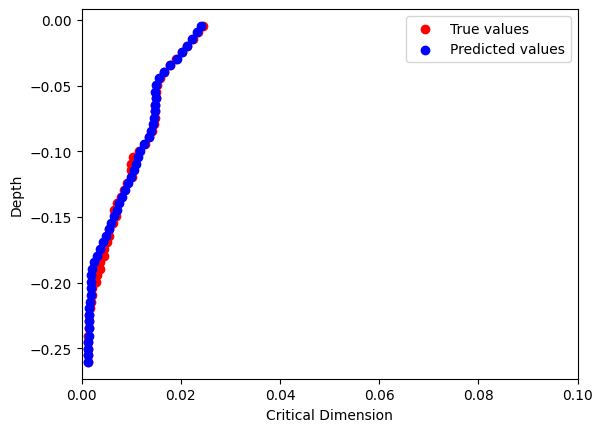

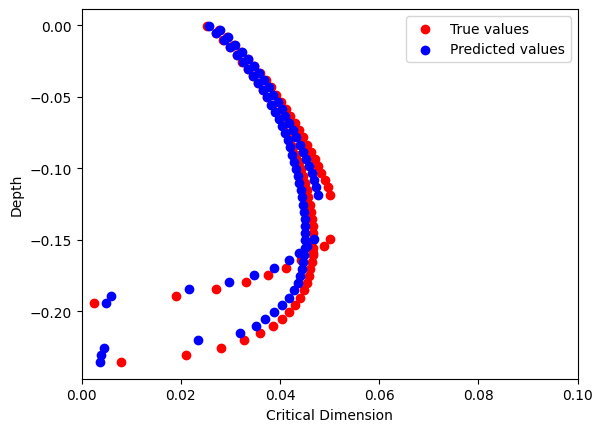

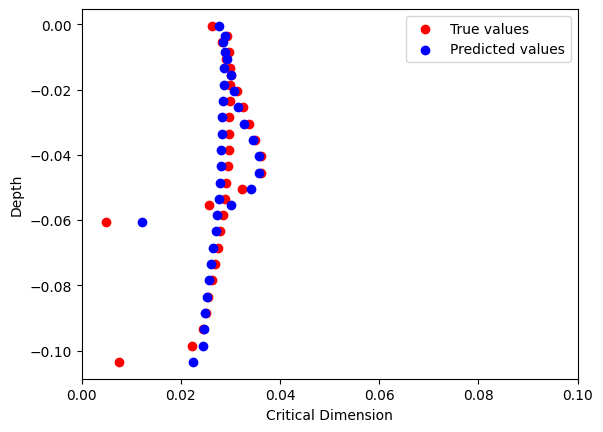

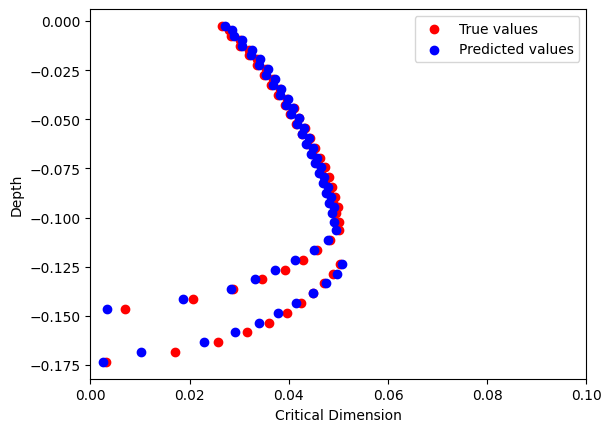

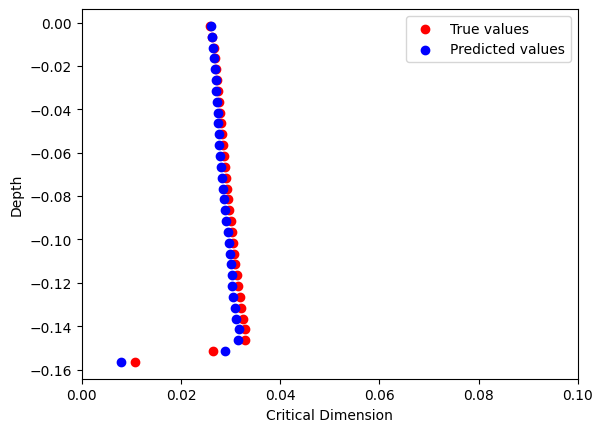

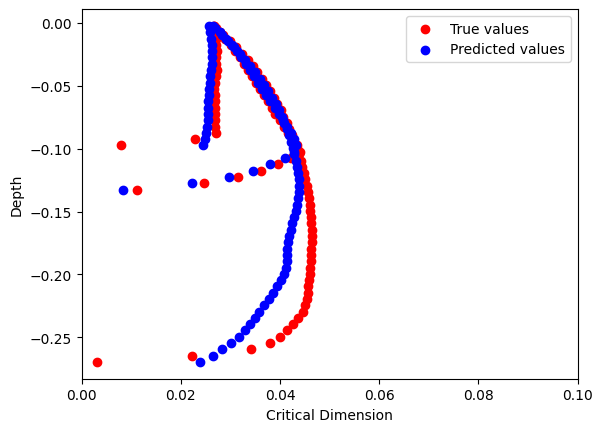

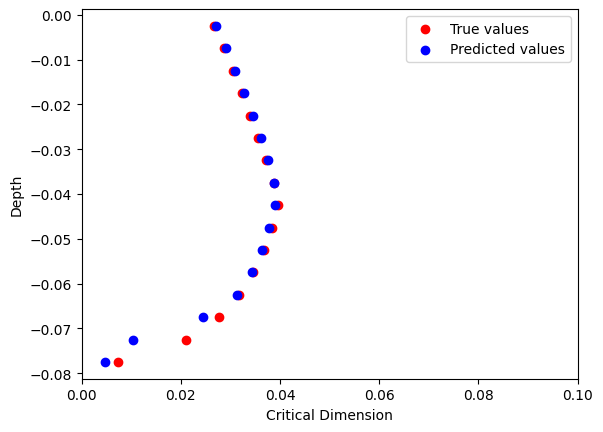

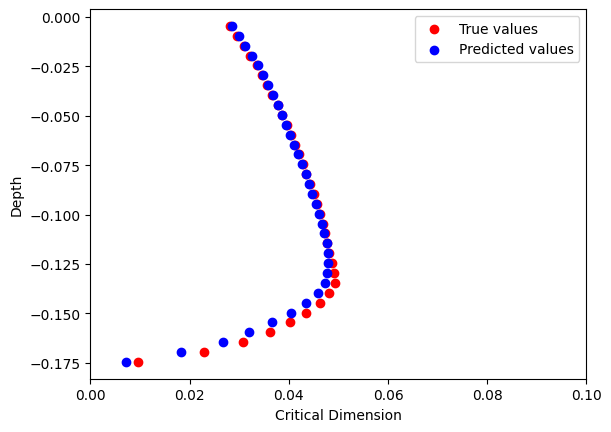

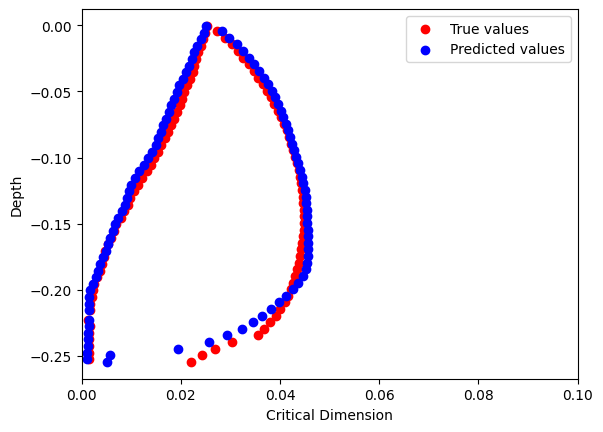

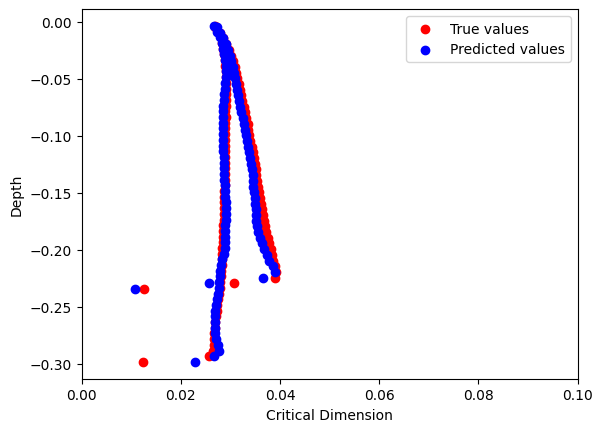

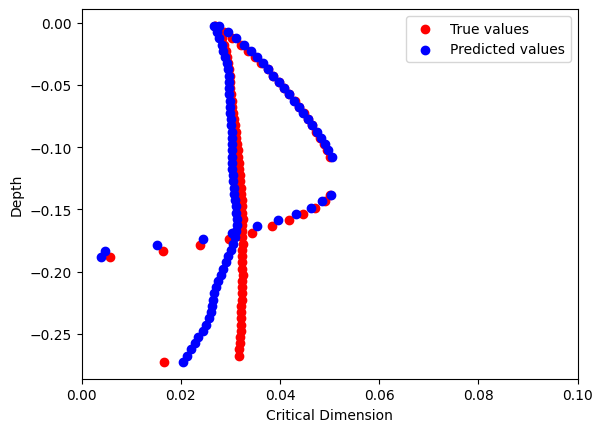

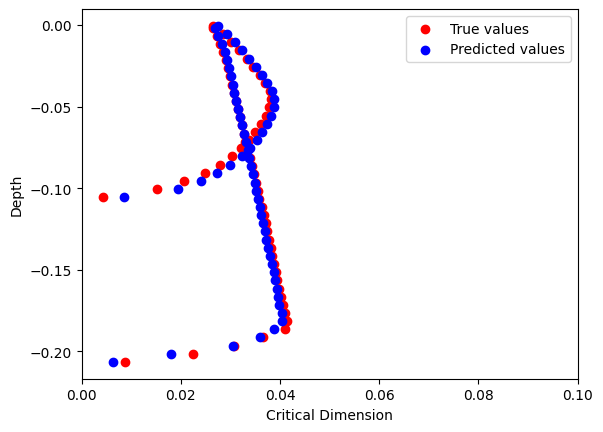

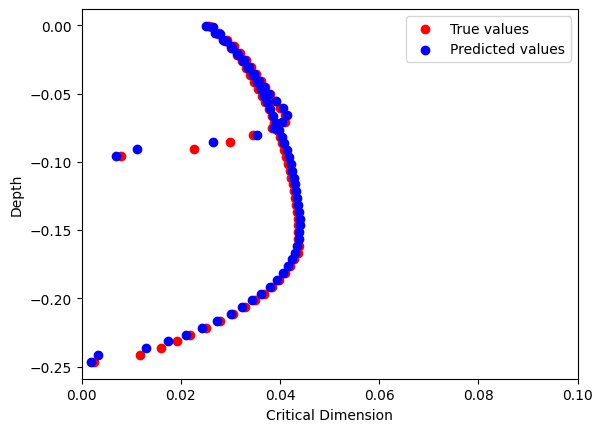

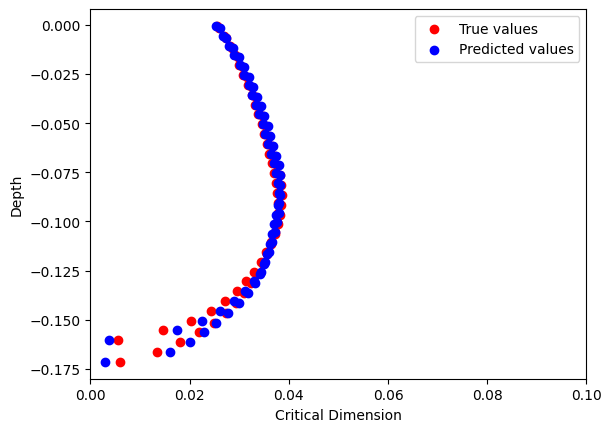

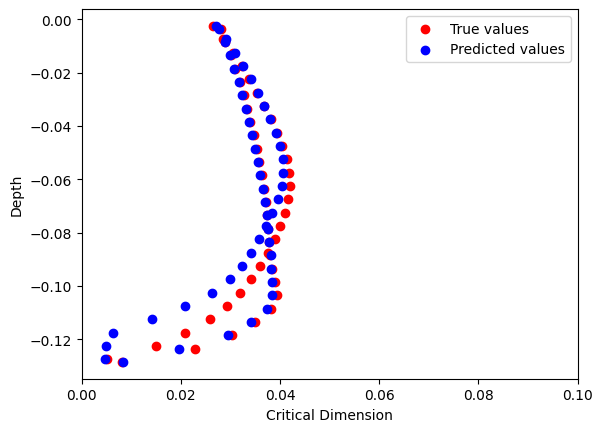

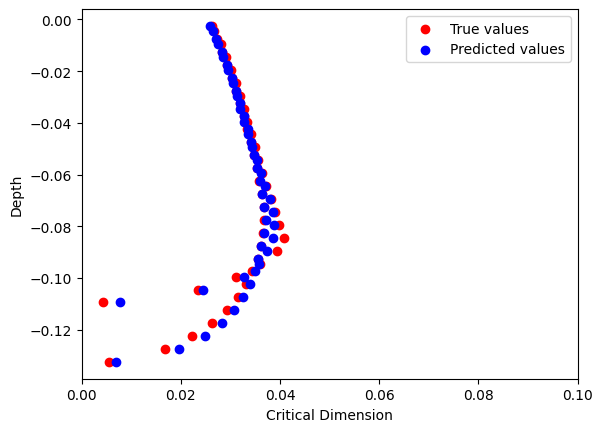

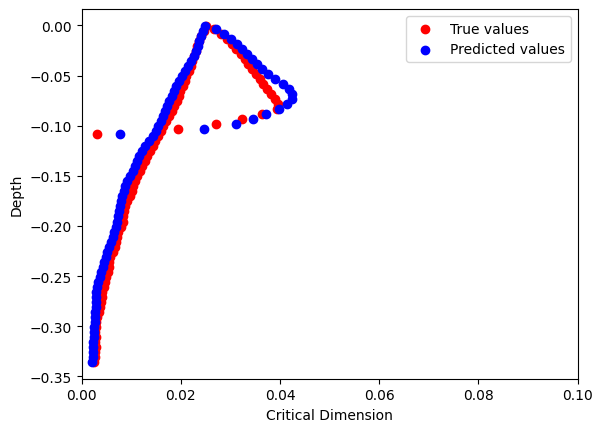

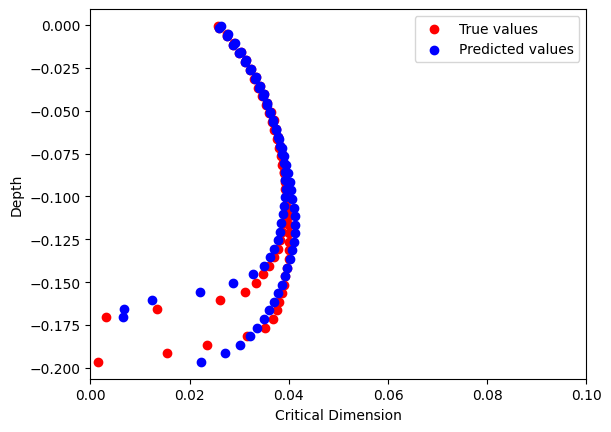

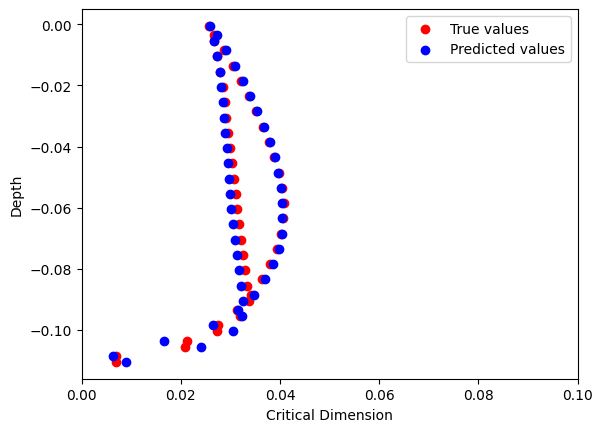

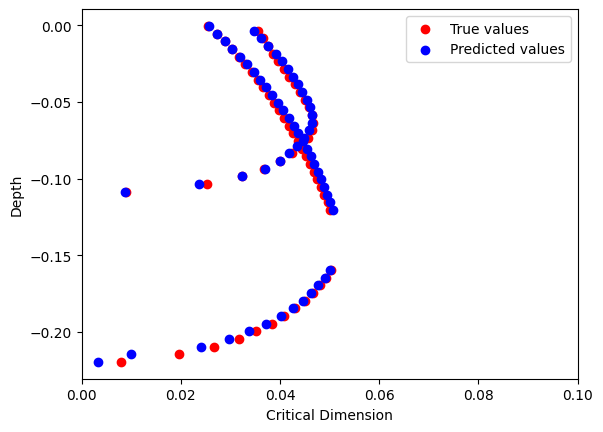

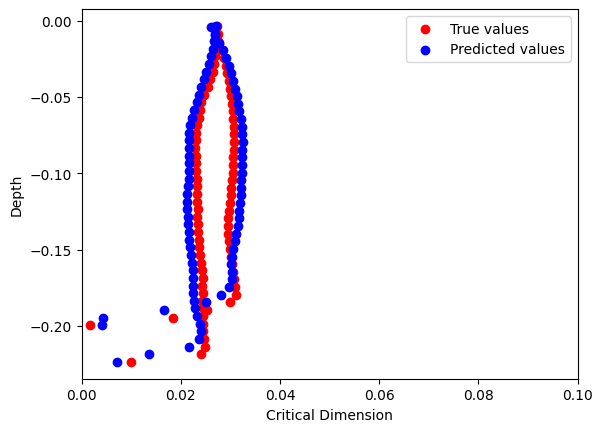

In [146]:
rev_index = indexes[::-1]
index = len(x_test)
count = 1
for i in rev_index:
    plt.figure()
    plt.xlim(0,0.1)
    plt.ylabel('Depth')
    plt.xlabel('Critical Dimension')
    plt.scatter(y_test.iloc[i:index,0],x_test.iloc[i:index,0], c='red',label=f'True values')
    plt.scatter(y_pred[i:index,0]/1000000, x_test.iloc[i:index,0],c='blue',label=f'Predicted values')
    plt.legend()
    plt.show()
    index = i
    if count==50: break
    count+=1

In [ ]:
# #CNN with LSTM
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, LSTM, Dense, Flatten, TimeDistributed, GlobalAveragePooling1D

# def create_conv_lstm_model(input_shape, num_classes):
#     model = tf.keras.Sequential()
    
#     # Convolutional layers
#     model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=input_shape))
#     model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=1, activation='relu'))
#     model.add(tf.keras.layers.Conv1D(filters=20, kernel_size=1, activation='relu'))
    
#     model.add(tf.keras.layers.GlobalAveragePooling1D())
#     model.add(tf.keras.layers.BatchNormalization())
    
#     # Flatten before feeding into LSTM
#     model.add(tf.keras.layers.Reshape((1, 20)))

#     # LSTM layers
#     model.add(tf.keras.layers.LSTM(200, return_sequences=True))
#     model.add(tf.keras.layers.LSTM(128))
    
#     # Fully connected layers
#     # model.add(tf.keras.layers.Dense(64, activation='relu'))
#     # model.add(tf.keras.layers.Dense(32, activation='relu'))
#     model.add(tf.keras.layers.Dense(num_classes))

#     # Compile the model
#     model.compile(optimizer='adam', loss='mae')
#     return model

# model = create_conv_lstm_model(input_shape=(X_train_scaled_reshaped.shape[1], X_train_scaled_reshaped.shape[2]), num_classes = 1)
# early_stopping = EarlyStopping(monitor='val_loss', patience=2, min_delta=0.0001, verbose=1)
# history = model.fit(X_train_scaled_reshaped, y_scale_arr, epochs=50, batch_size=64, verbose=1, validation_data=(X_test_scaled_reshaped, y_scale_t_arr), 
#                     callbacks=[early_stopping]
#                     )

# # val_loss = model.evaluate(X_valid_scaled_reshaped,y_scale_v_arr)
# # print(f'Validation Loss: {val_loss}')

# # Predict on the test set
# y_pred = model.predict(X_test_scaled_reshaped)

Epoch 1/50
3828/3828 [==============================] - 41s 10ms/step - loss: 0.2835 - val_loss: 0.2307
Epoch 2/50
3828/3828 [==============================] - 35s 9ms/step - loss: 0.1922 - val_loss: 0.1921
Epoch 3/50
3828/3828 [==============================] - 35s 9ms/step - loss: 0.1698 - val_loss: 0.1615
Epoch 4/50
3828/3828 [==============================] - 35s 9ms/step - loss: 0.1564 - val_loss: 0.1686
Epoch 5/50
3828/3828 [==============================] - 35s 9ms/step - loss: 0.1478 - val_loss: 0.1562
Epoch 6/50
3828/3828 [==============================] - 36s 10ms/step - loss: 0.1402 - val_loss: 0.1478
Epoch 7/50
3828/3828 [==============================] - 35s 9ms/step - loss: 0.1348 - val_loss: 0.1454
Epoch 8/50
3828/3828 [==============================] - 35s 9ms/step - loss: 0.1291 - val_loss: 0.1533
Epoch 9/50
3828/3828 [==============================] - 32s 8ms/step - loss: 0.1259 - val_loss: 0.1494
Epoch 9: early stopping
1870/1870 [==============================] - 5s

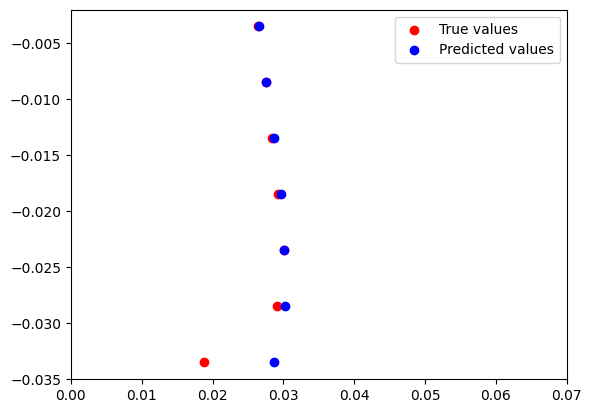

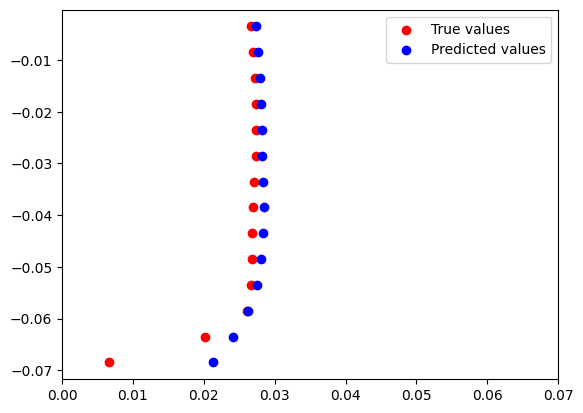

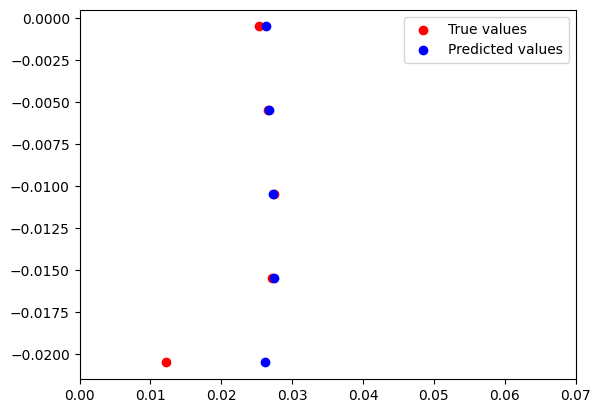

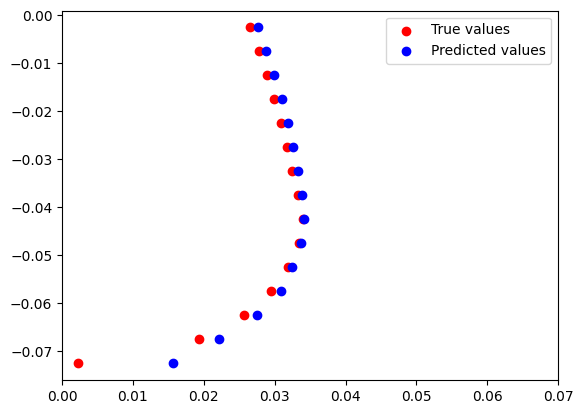

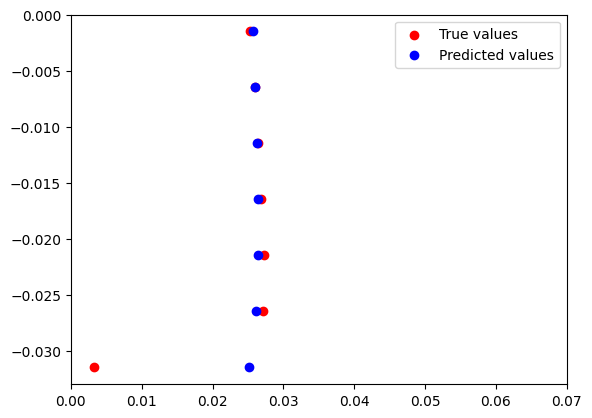

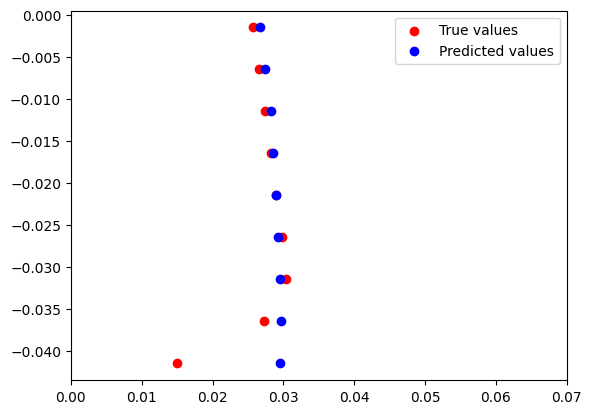

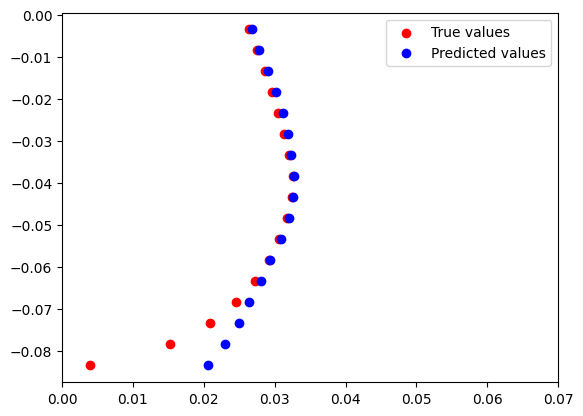

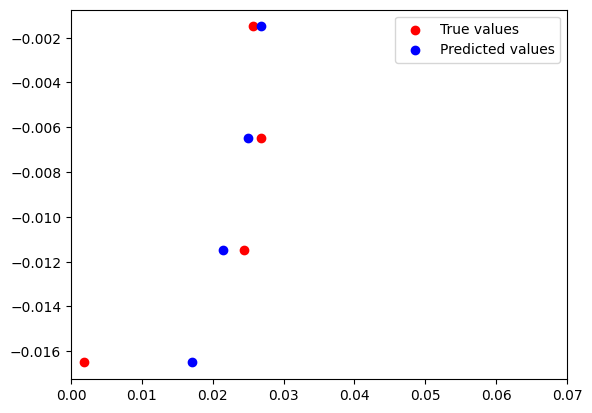

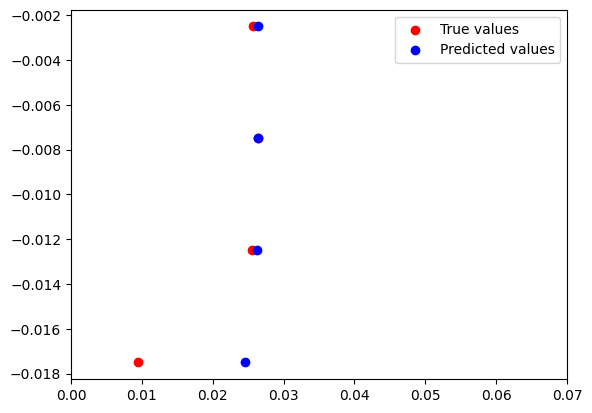

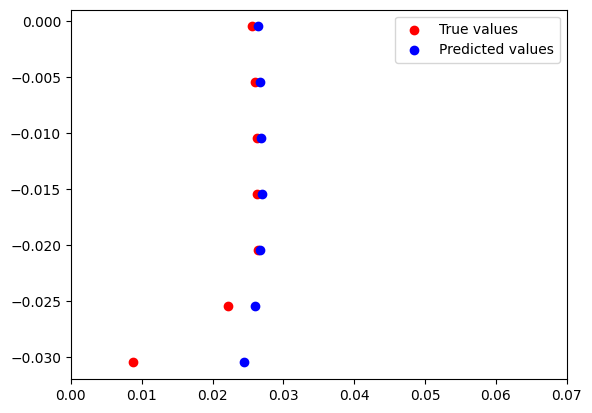

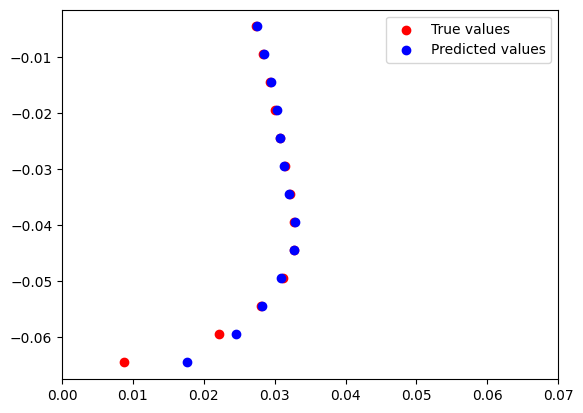

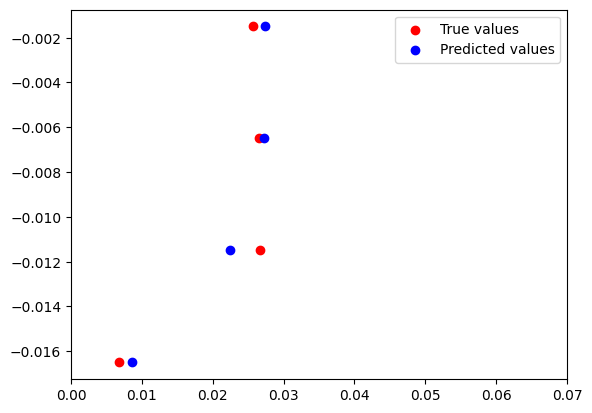

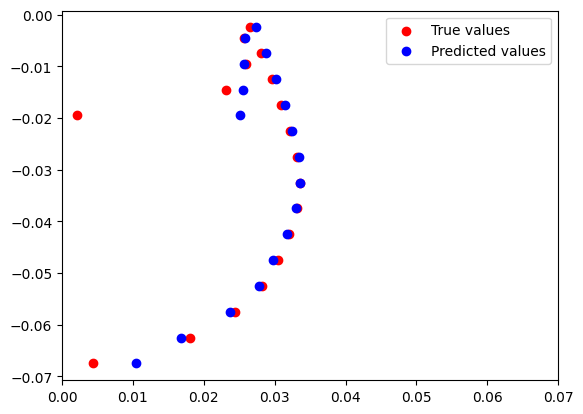

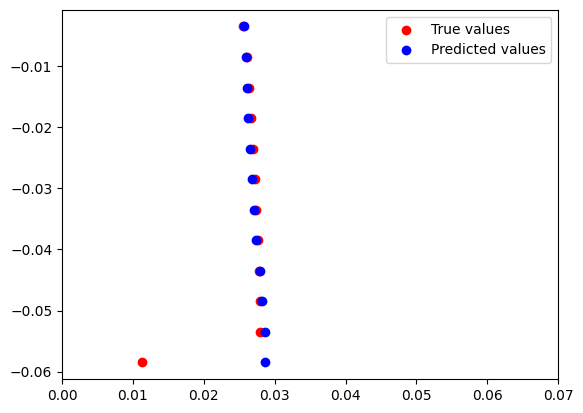

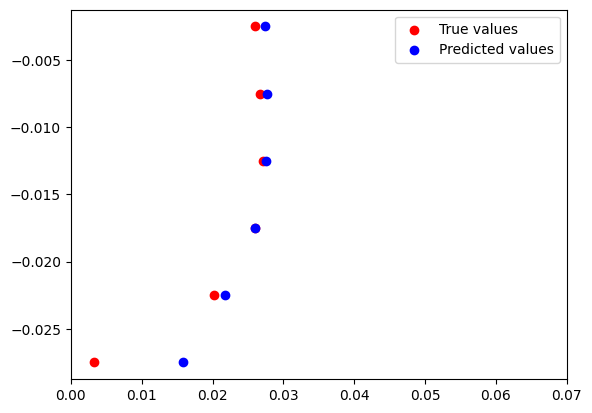


t=12



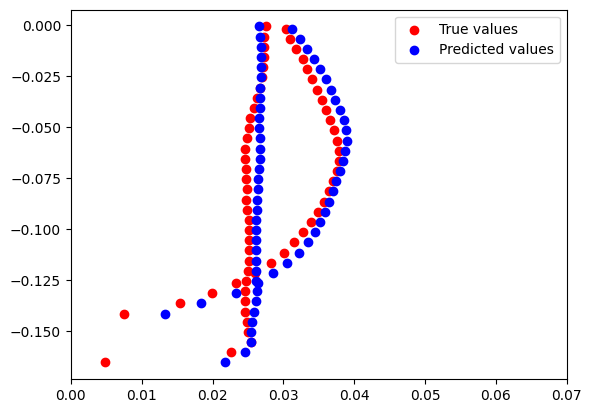

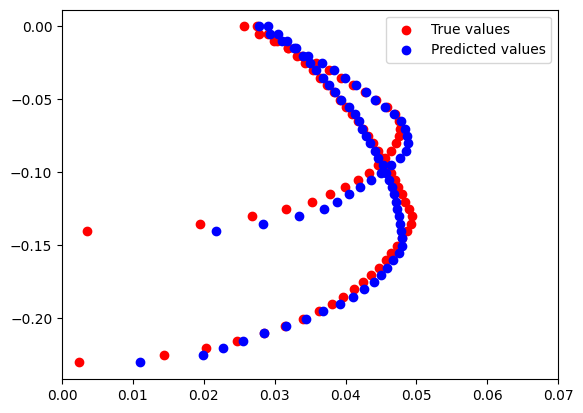

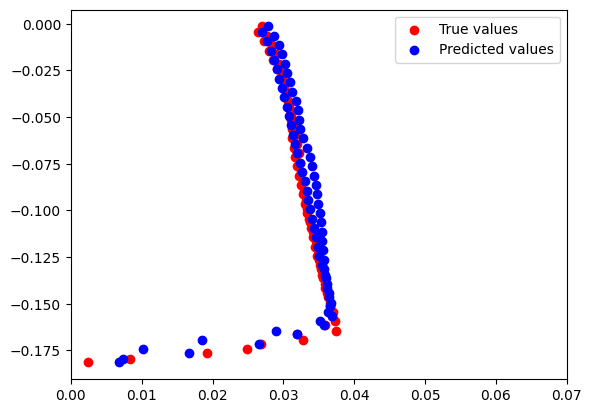

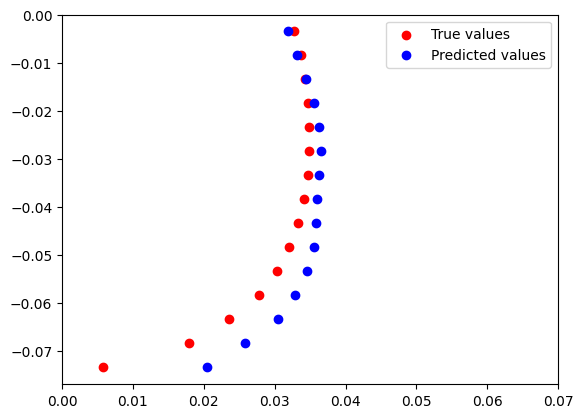

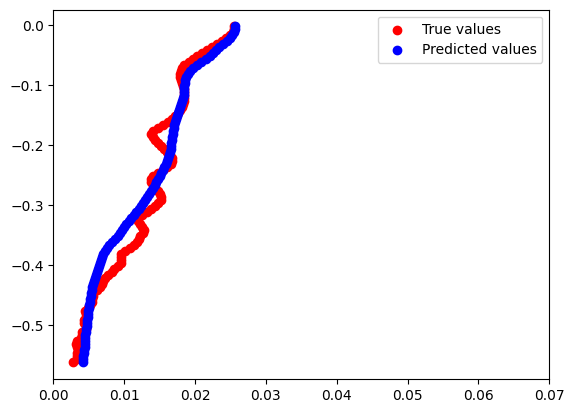

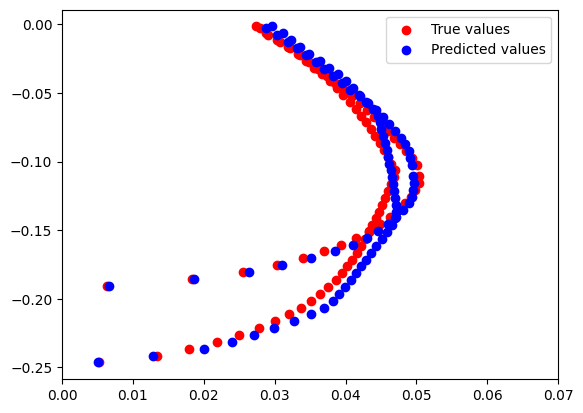

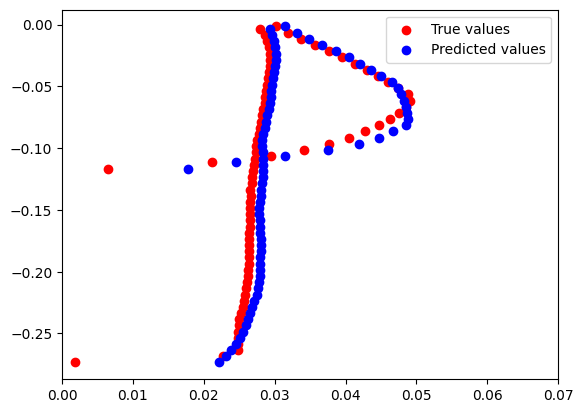

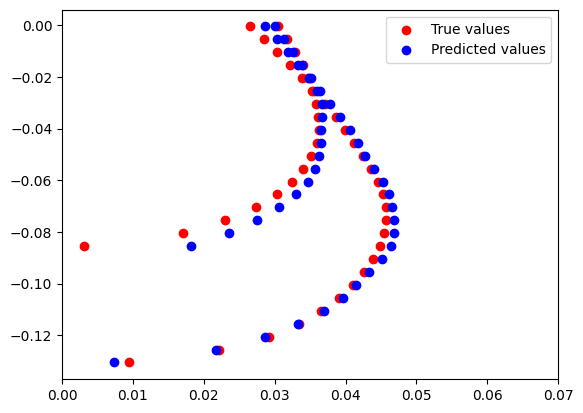

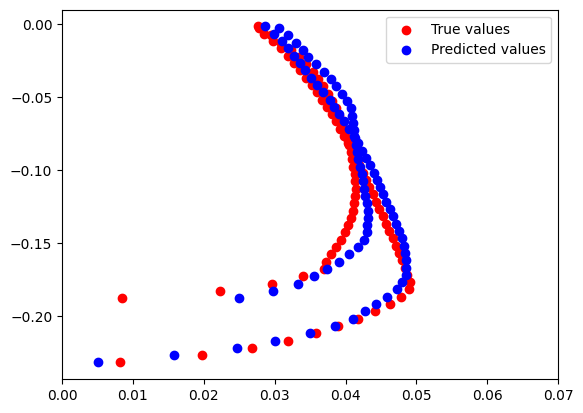

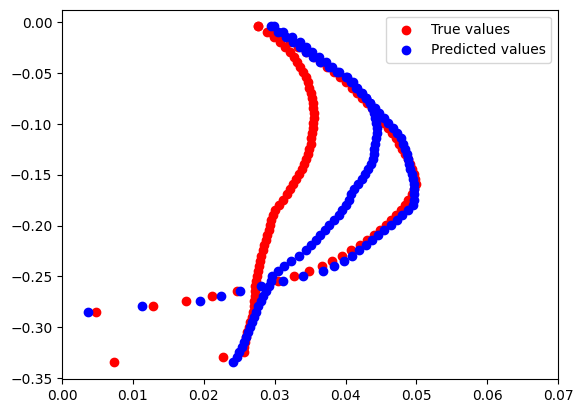

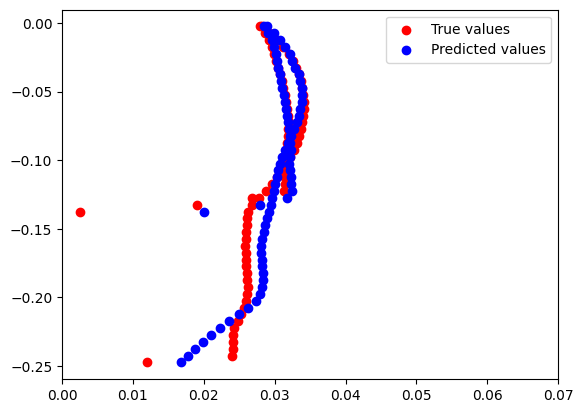

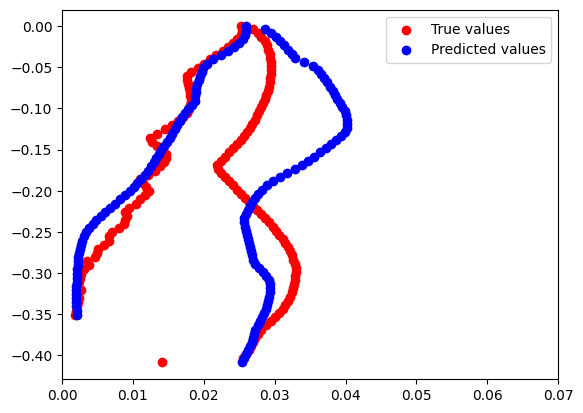

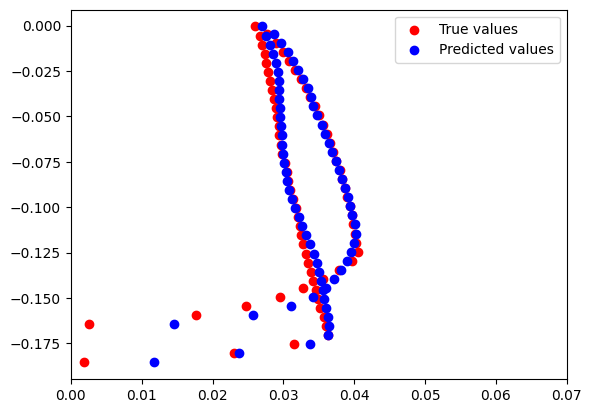

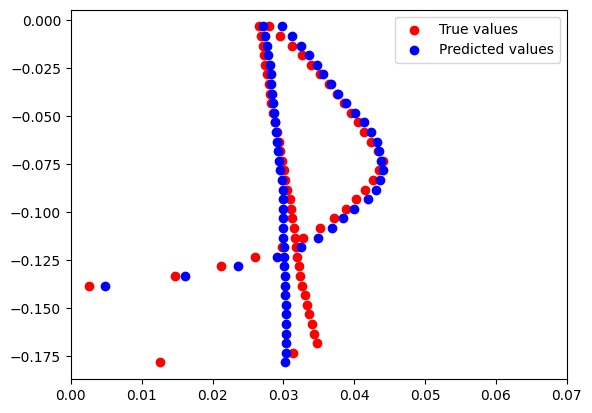

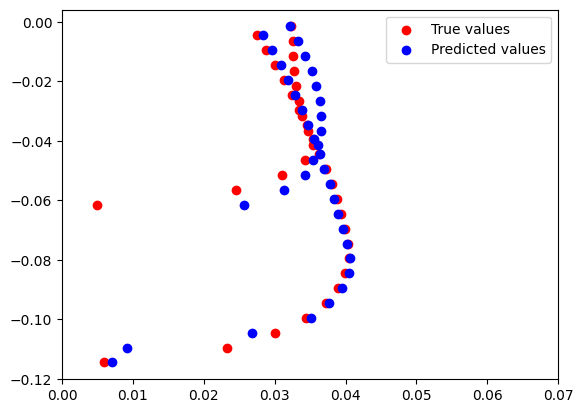

In [ ]:
# index = 0
# count = 1
# for i in indexes:
#     plt.figure()
#     plt.xlim(0,0.07)
#     plt.scatter(y_test.iloc[index:i,0],x_test.iloc[index:i,0], c='red',label=f'True values')
#     plt.scatter(predictions[index:i,0],x_test_plot[index:i,0],c='blue',label=f'Predicted values')
#     plt.legend()
#     plt.show()
#     index = i
#     if count==15: break
#     count+=1
# print('\nt=12\n')
# rev_index = indexes[::-1]
# index = len(x_test)
# count = 1
# for i in rev_index:
#     plt.figure()
#     plt.xlim(0,0.07)
#     plt.scatter(y_test.iloc[i:index,0],x_test.iloc[i:index,0], c='red',label=f'True values')
#     plt.scatter(predictions[i:index,0], x_test_plot[i:index,0],c='blue',label=f'Predicted values')
#     plt.legend()
#     plt.show()
#     index = i
#     if count==15: break
#     count+=1

In [ ]:
# #RNN
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Input
# from tensorflow.keras.callbacks import EarlyStopping

# def create_rnn_model(input_shape):
#     model = Sequential()
#     model.add(Input(shape=input_shape))
#     # model.add(SimpleRNN(8192, return_sequences=True, activation='relu'))
#     model.add(SimpleRNN(4096, return_sequences=True, activation='relu'))
#     model.add(SimpleRNN(2048, return_sequences=True, activation='relu'))
#     model.add(SimpleRNN(1024, return_sequences=True, activation='relu'))
#     model.add(SimpleRNN(512, return_sequences=True, activation='relu'))
#     model.add(SimpleRNN(256, return_sequences=True, activation='relu'))
#     # model.add(Dropout(0.3))
#     model.add(SimpleRNN(128, return_sequences=True, activation='relu'))
#     # model.add(Dropout(0.3))
#     model.add(SimpleRNN(64, activation='relu'))
#     model.add(Dropout(0.2))
#     model.add(Dense(1))  # Assuming 1 target variable
#     model.compile(optimizer='adam', loss='mape')
#     return model

# # Assuming X_train_scaled_reshaped and X_test_scaled_reshaped are 3D arrays
# # and the input shape is (time_steps, number of features)
# input_shape = (X_train_scaled_reshaped.shape[1], X_train_scaled_reshaped.shape[2])

# model = create_rnn_model(input_shape=input_shape)
# early_stopping = EarlyStopping(monitor='val_loss', patience=30, min_delta=0.0001, verbose=1)

# history = model.fit(X_train_scaled_reshaped, y_train_scale, epochs=500, batch_size=64, verbose=1, 
#                     validation_data=(X_test_scaled_reshaped, y_test_scale), 
#                     # callbacks=[early_stopping]
#                     )

# # Predict on the test set
# y_pred = model.predict(X_test_scaled_reshaped)

# print(f'Loss: {relative_mean_absolute_error(y_test_scale, y_pred)}')

In [21]:
# model.save_weights('model_2_rnn_intermediate.weights.h5')


In [22]:
# model.load_weights('model_2_rnn_intermediate.weights.h5')

# history = model.fit(X_train_scaled_reshaped, y_train_scale, epochs=500, batch_size=64, verbose=1, 
#                     validation_data=(X_test_scaled_reshaped, y_test_scale), 
#                     # callbacks=[early_stopping]
#                     )

# # Predict on the test set
# y_pred = model.predict(X_test_scaled_reshaped)

# print(f'Loss: {relative_mean_absolute_error(y_test_scale, y_pred)}')

Epoch 1/500
3828/3828 ━━━━━━━━━━━━━━━━━━━━ 1708s 446ms/step - loss: 18.6620 - val_loss: 15.9754
Epoch 2/500
3828/3828 ━━━━━━━━━━━━━━━━━━━━ 4507s 1s/step - loss: 17.4343 - val_loss: 13.8409
Epoch 3/500
  15/3828 ━━━━━━━━━━━━━━━━━━━━ 32:11 507ms/step - loss: 14.0257

KeyboardInterrupt: 

In [23]:
# y_pred = model.predict(X_test_scaled_reshaped)

# print(f'Loss: {relative_mean_absolute_error(y_test_scale, y_pred)}')

1870/1870 ━━━━━━━━━━━━━━━━━━━━ 83s 43ms/step
Loss: 0.1635241582131665


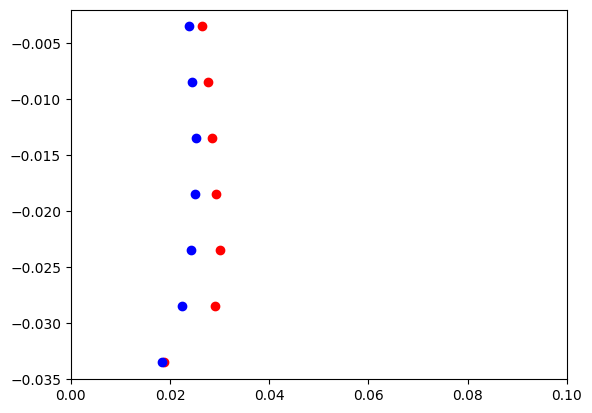

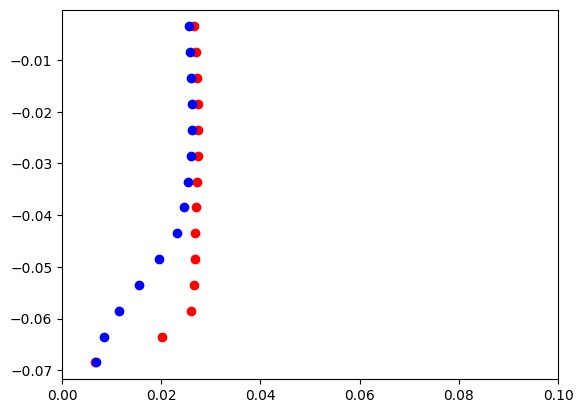

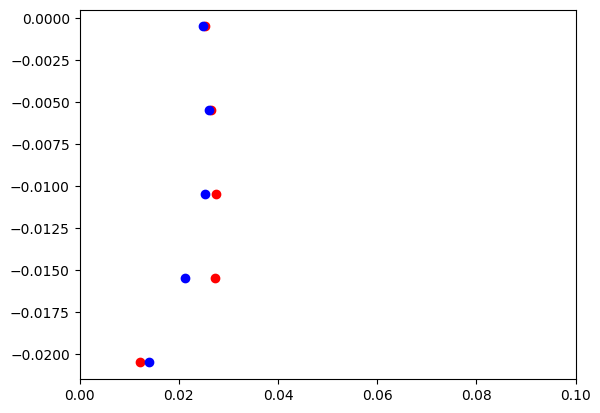

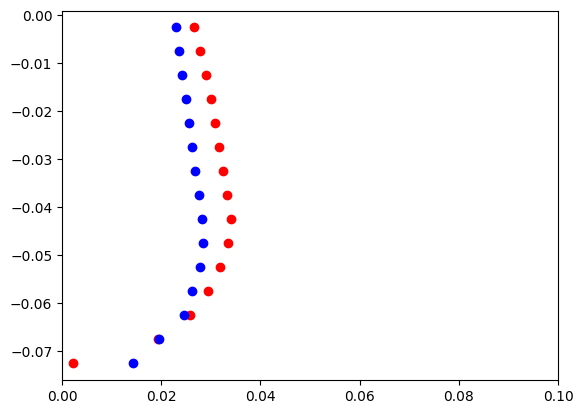

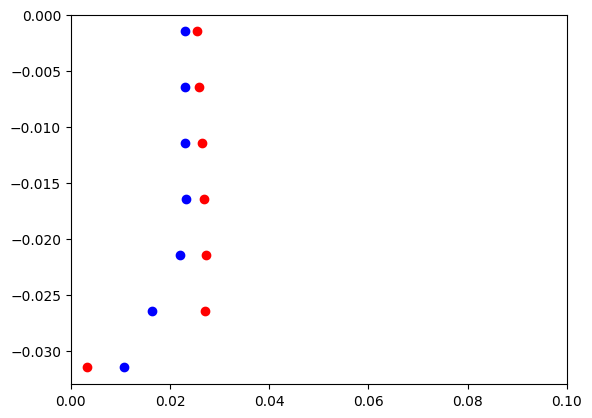

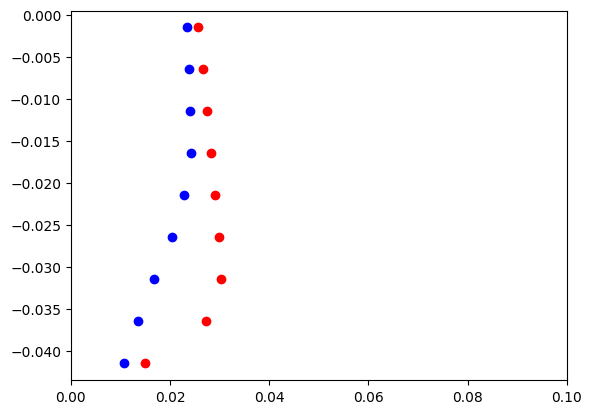

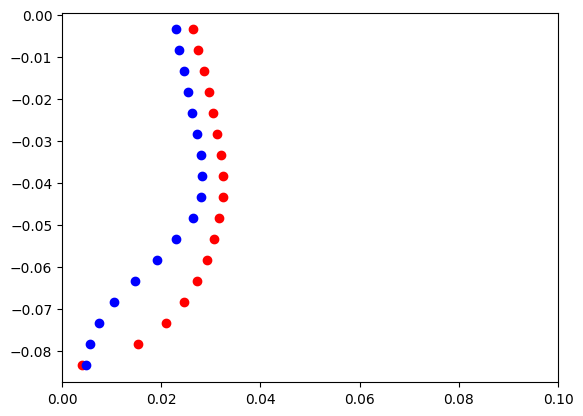

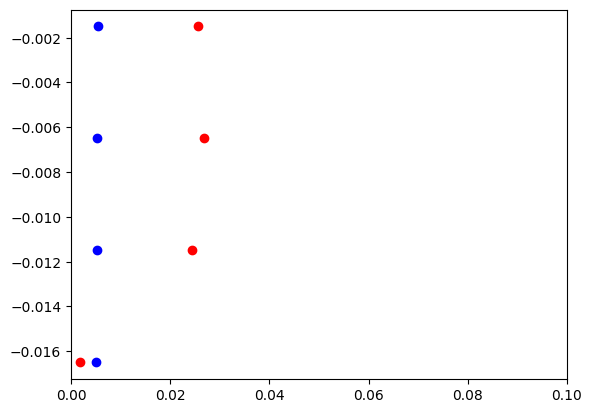

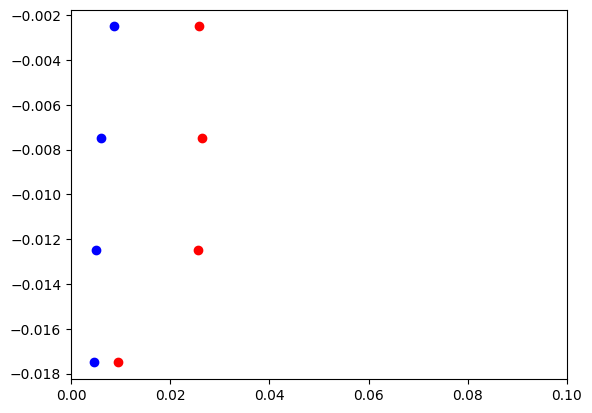

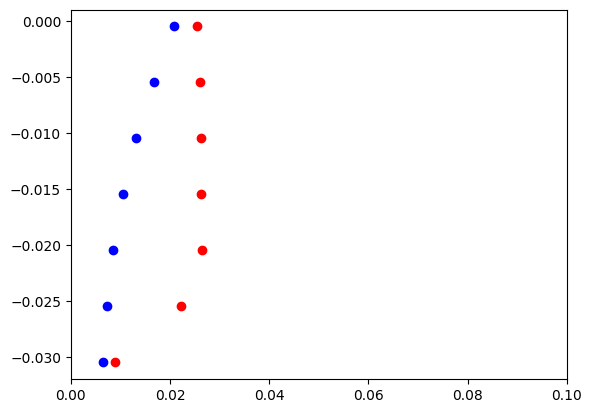

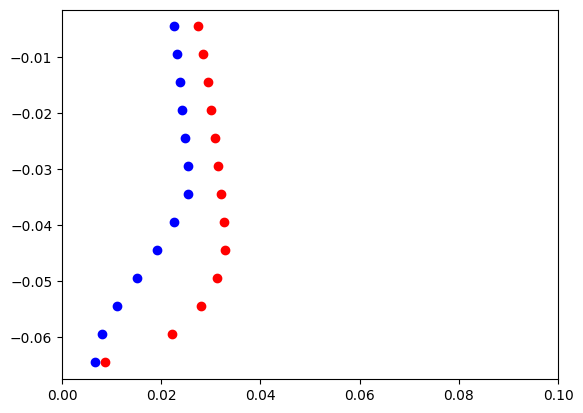

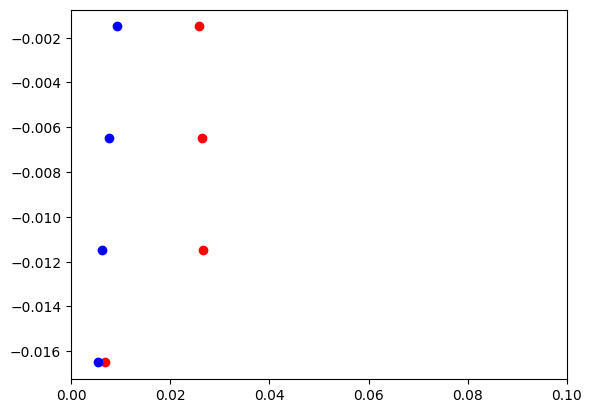

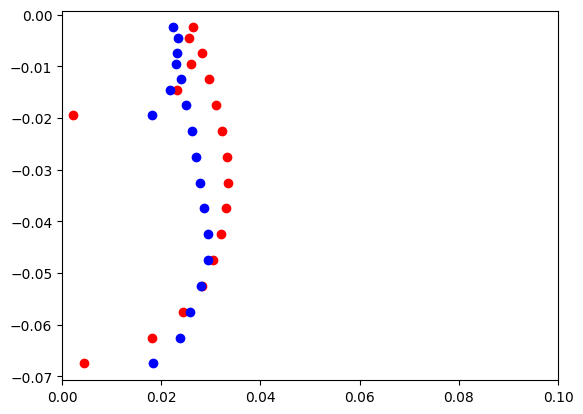

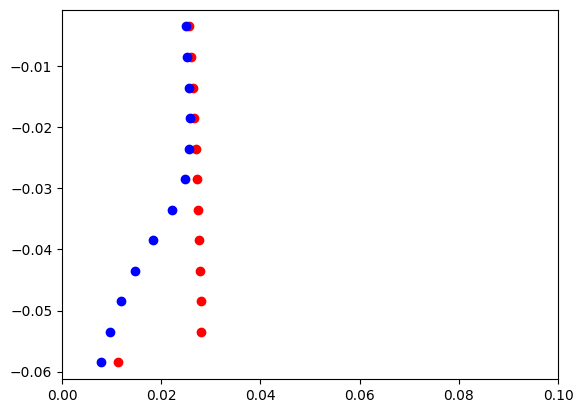

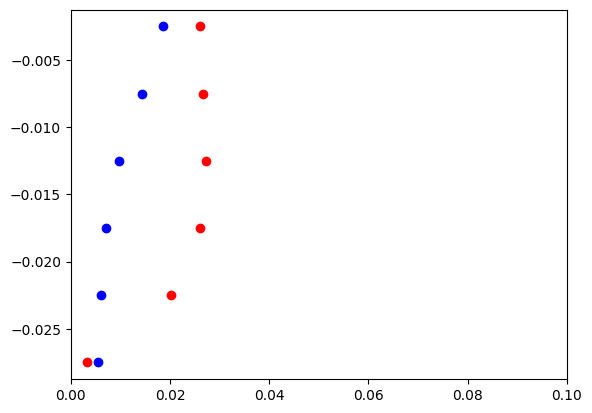

In [25]:
# index = 0
# count = 1
# for i in indexes:
#     plt.figure()
#     plt.xlim(0,0.1)
#     plt.scatter(y_test.iloc[index:i,0],x_test.iloc[index:i,0], c='red',label=f'True values')
#     plt.scatter(y_pred[index:i,0]/1000000,x_test.iloc[index:i,0],c='blue',label=f'Predicted values')
#     plt.show()
#     index = i
#     if count==15: break
#     count+=1

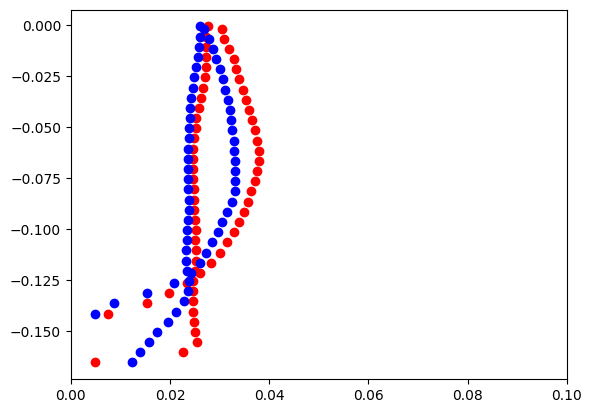

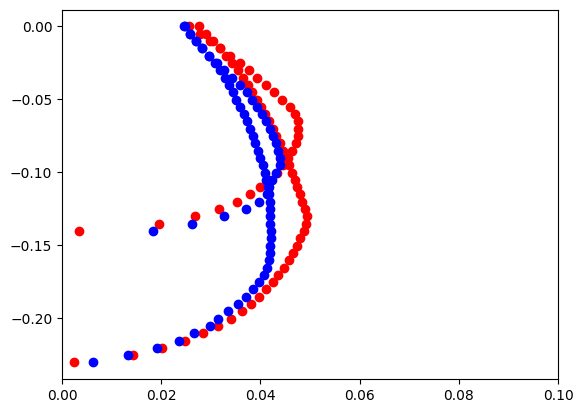

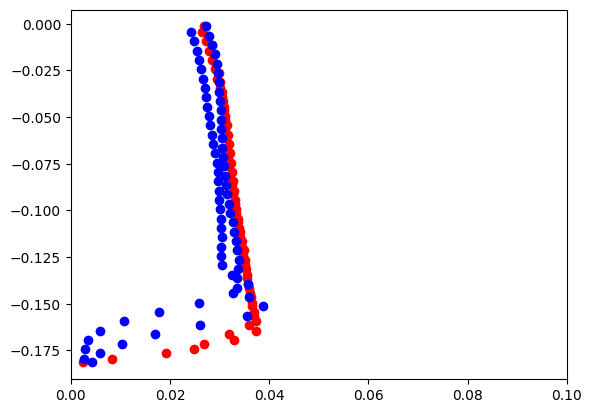

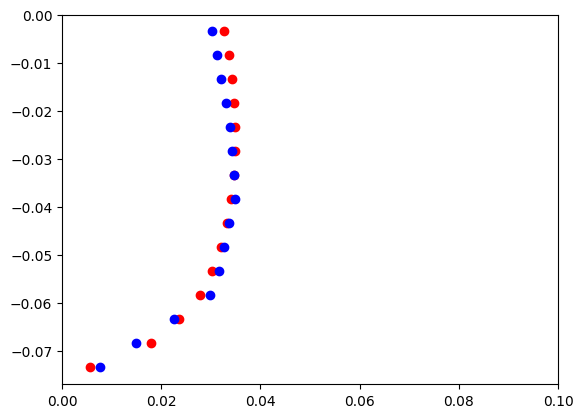

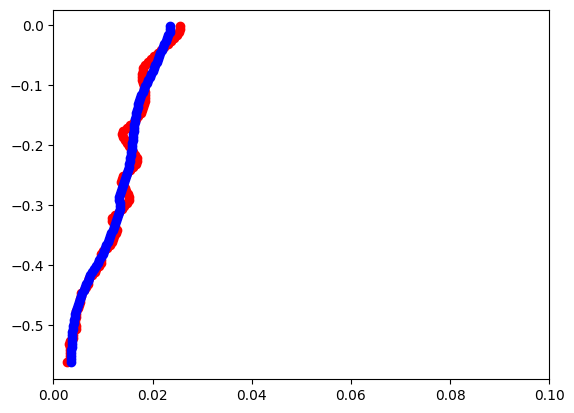

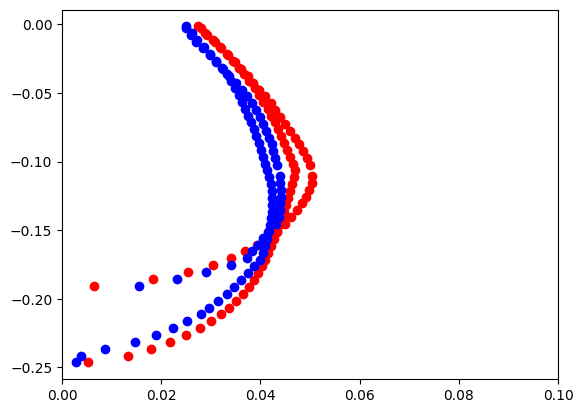

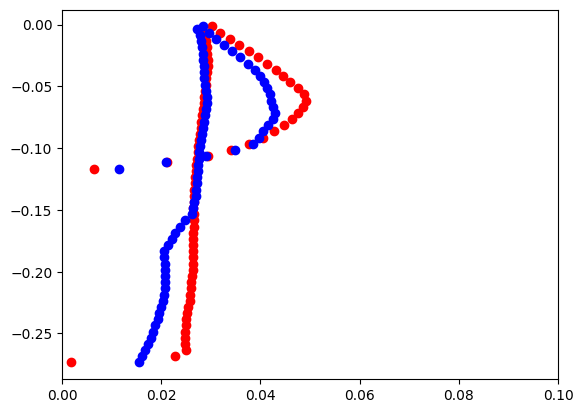

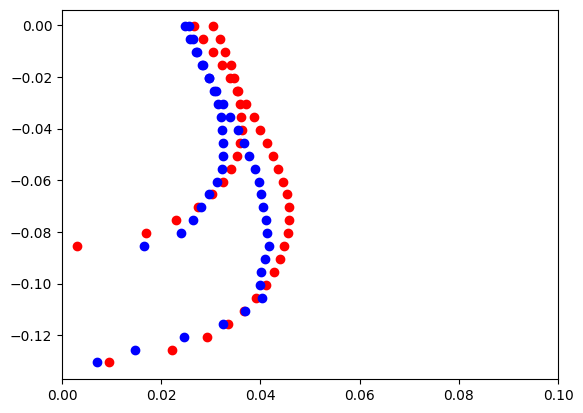

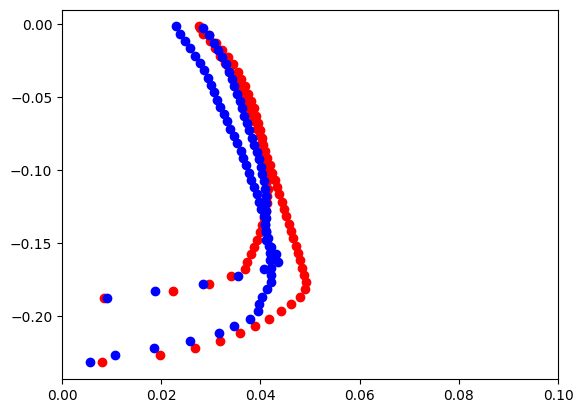

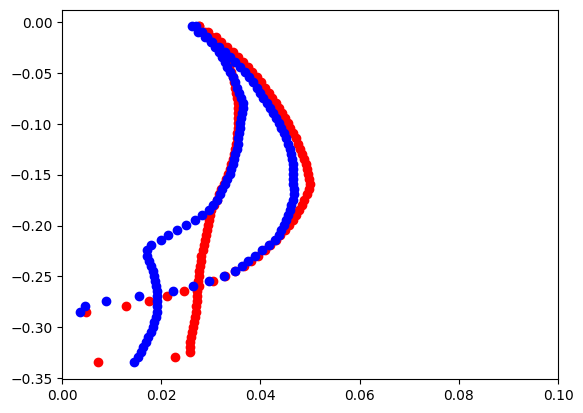

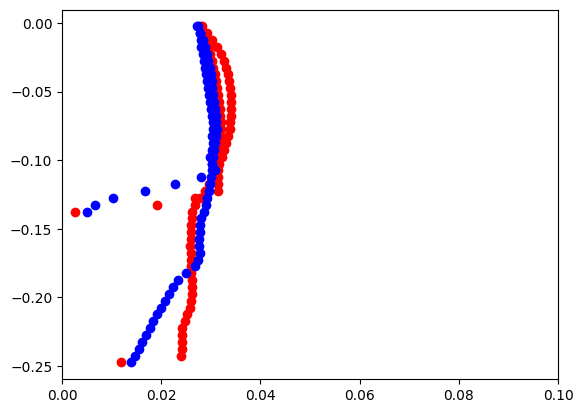

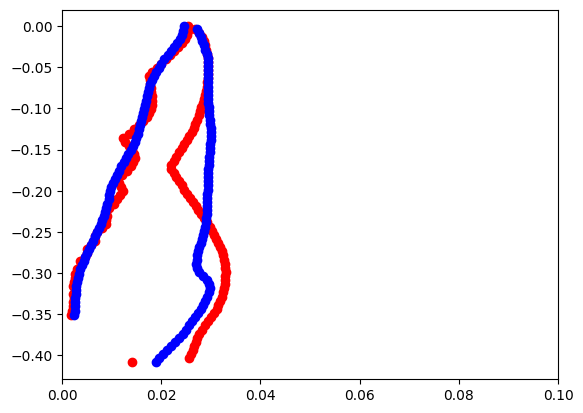

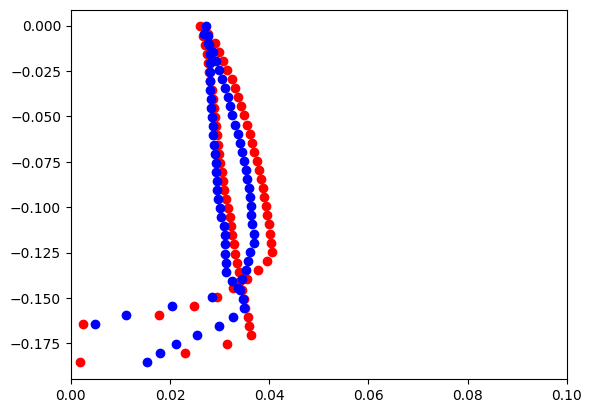

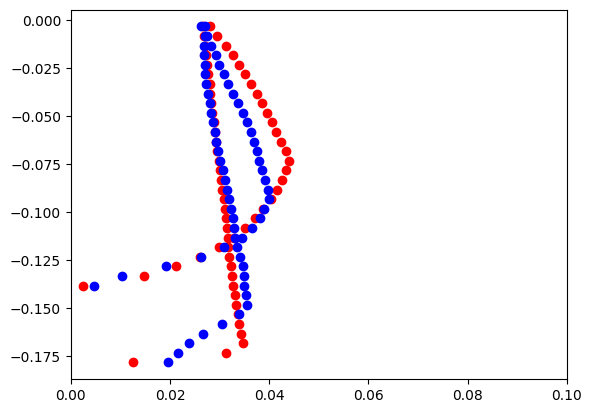

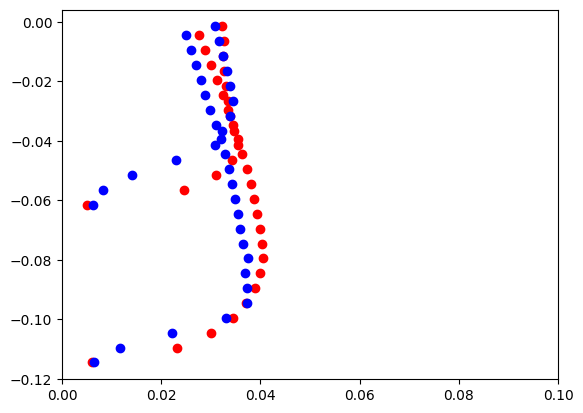

In [26]:
rev_index = indexes[::-1]
index = len(x_test)
count = 1
for i in rev_index:
    plt.figure()
    plt.xlim(0,0.1)
    plt.scatter(y_test.iloc[i:index,0],x_test.iloc[i:index,0], c='red',label=f'True values')
    plt.scatter(y_pred[i:index,0]/1000000, x_test.iloc[i:index,0],c='blue',label=f'Predicted values')
    plt.show()
    index = i
    if count==15: break
    count+=1

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, Input
# from tensorflow.keras.callbacks import EarlyStopping

# def create_ann_model(input_shape):
#     model = Sequential()
#     model.add(Input(shape=(input_shape,)))
#     # model.add(Dense(4096, activation='relu'))
#     model.add(Dense(2048, activation='relu'))
#     model.add(Dense(1024, activation='relu'))
#     model.add(Dense(512, activation='relu'))
#     model.add(Dense(256, activation='relu'))
#     model.add(Dense(128, activation='relu'))
#     model.add(Dense(64, activation='relu'))
#     model.add(Dropout(0.2))
#     model.add(Dense(1))  # Assuming 1 target variable
#     model.compile(optimizer='adam', loss='mape')
#     return model

# # Assuming X_train_scaled_reshaped and X_test_scaled_reshaped are 2D arrays
# # Flatten the 3D arrays to 2D arrays
# X_train_scaled_flat = X_train_scaled_reshaped.reshape(X_train_scaled_reshaped.shape[0], -1)
# X_test_scaled_flat = X_test_scaled_reshaped.reshape(X_test_scaled_reshaped.shape[0], -1)

# # The input shape is the number of features
# input_shape = X_train_scaled_flat.shape[1]

# model = create_ann_model(input_shape=input_shape)
# early_stopping = EarlyStopping(monitor='val_loss', patience=30, min_delta=0.0001, verbose=1)

# history = model.fit(X_train_scaled_flat, y_train_scale, epochs=100, batch_size=256, verbose=1, 
#                     validation_data=(X_test_scaled_flat, y_test_scale), 
#                     # callbacks=[early_stopping]
#                     )

# # Predict on the test set
# y_pred = model.predict(X_test_scaled_flat)

# # Assuming relative_mean_absolute_error is defined somewhere in your code
# print(f'Loss: {relative_mean_absolute_error(y_test_scale, y_pred)}')


In [139]:
y_pred = model.predict(X_test_scaled_flat)

# Assuming relative_mean_absolute_error is defined somewhere in your code
print(f'Loss: {relative_mean_absolute_error(y_test_scale, y_pred)}')

1870/1870 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step
Loss: 0.09475989930374407


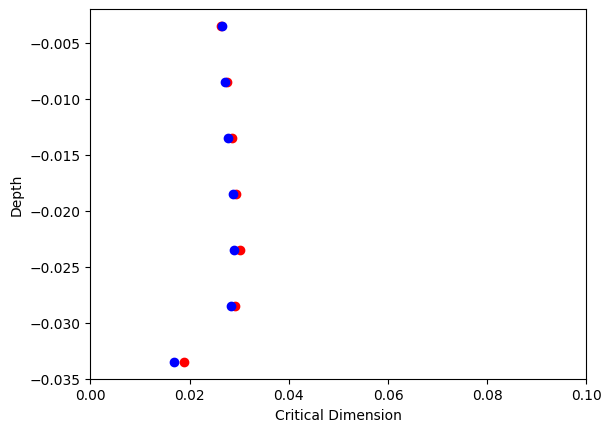

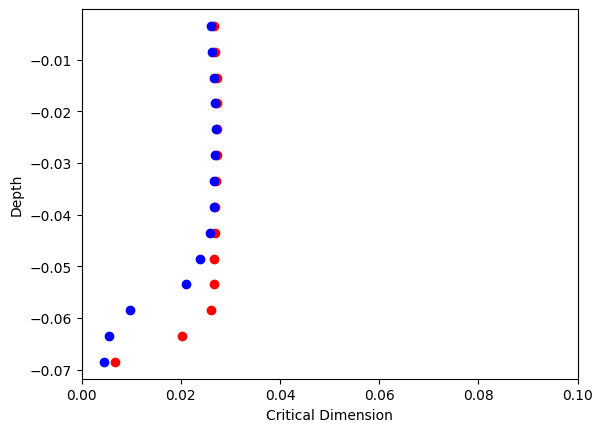

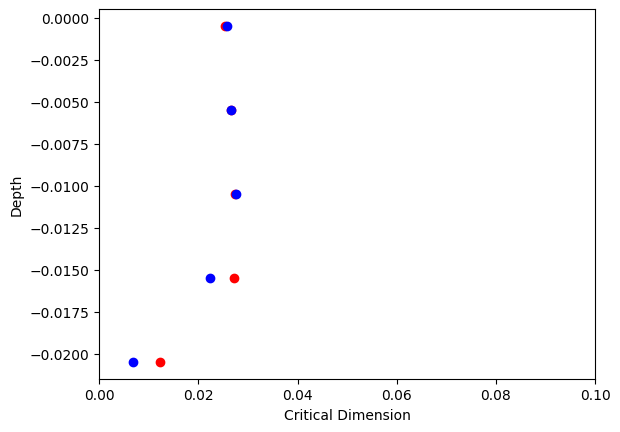

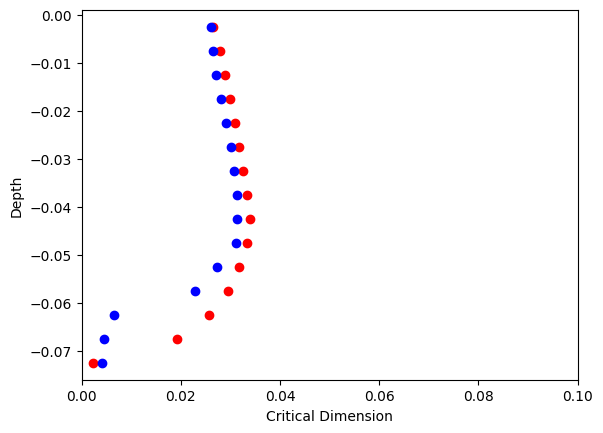

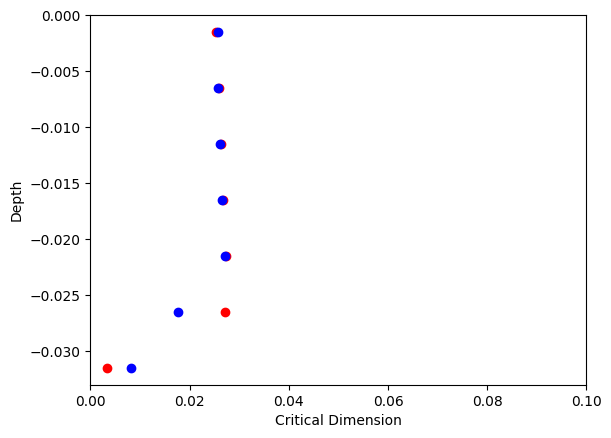

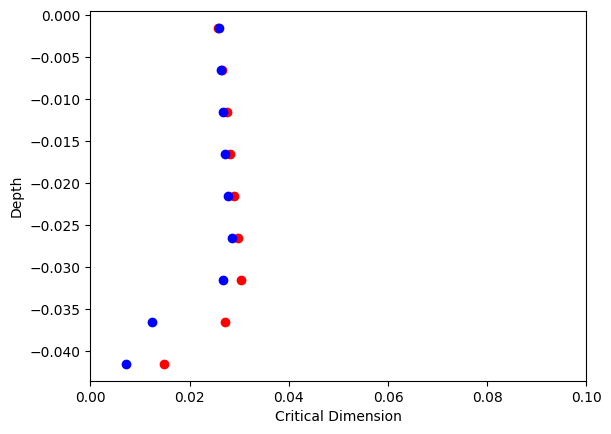

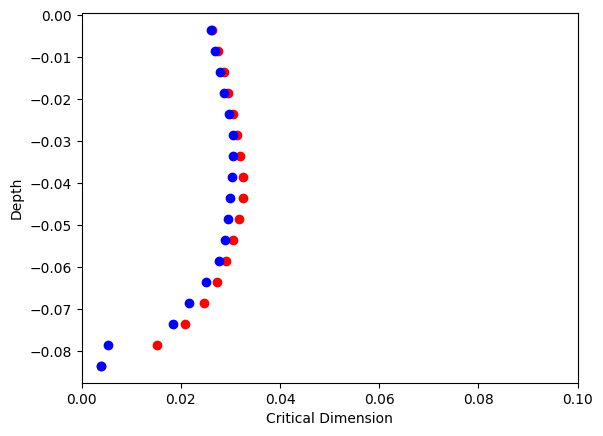

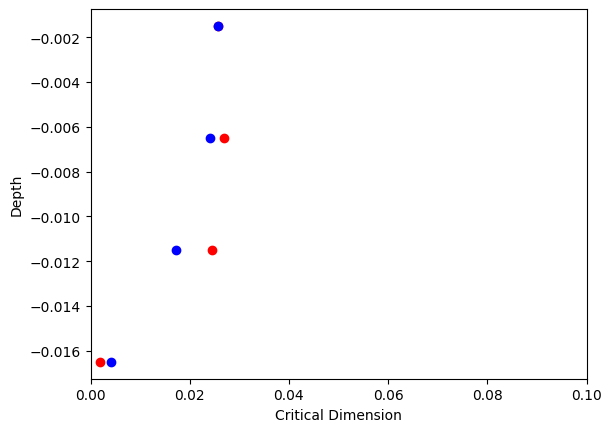

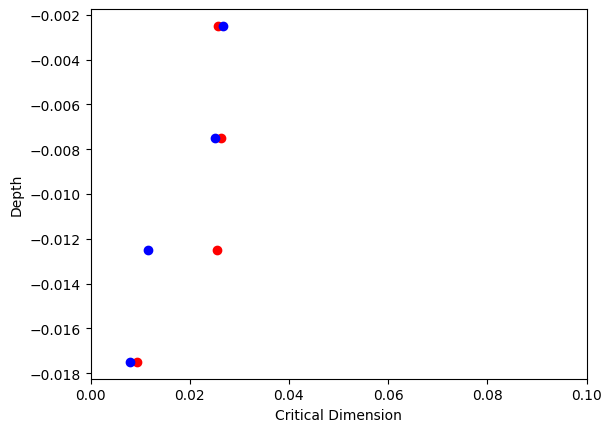

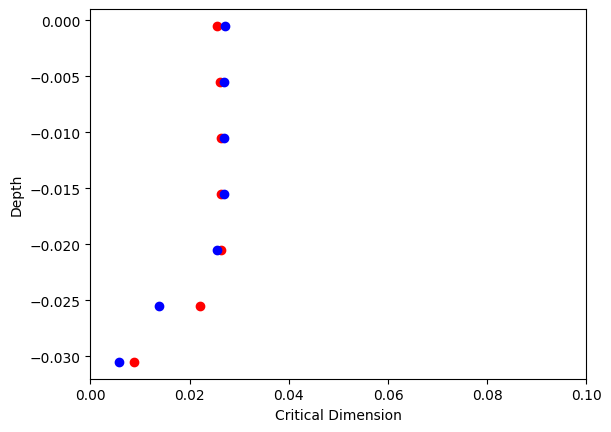

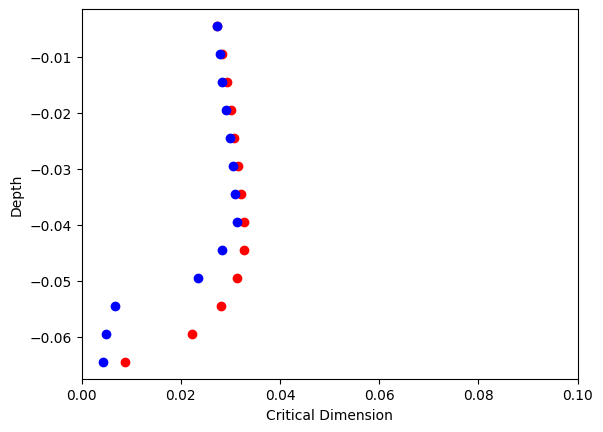

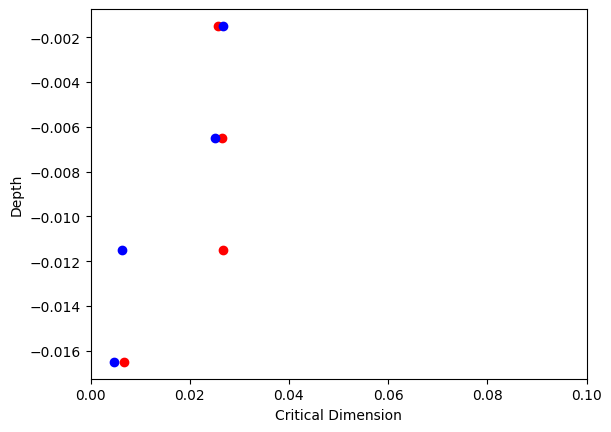

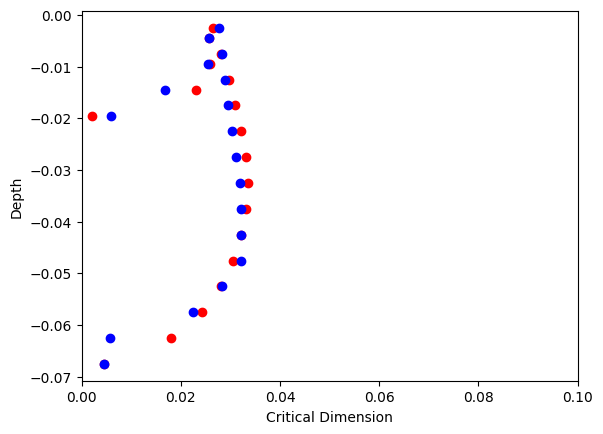

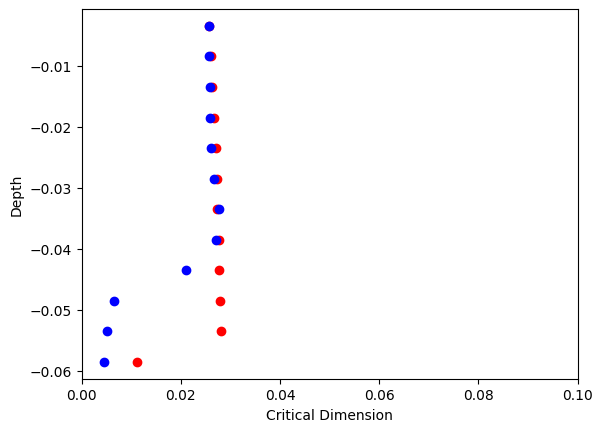

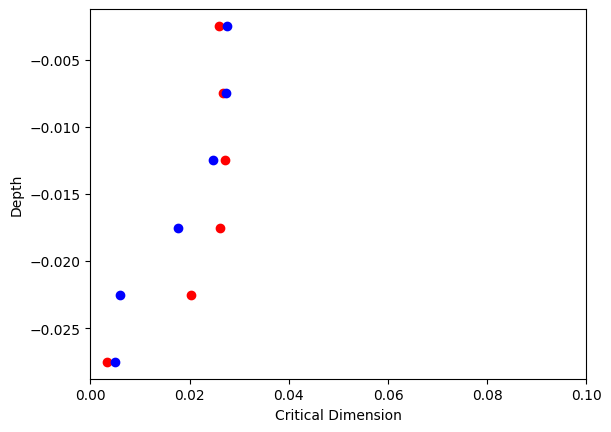

In [141]:
# index = 0
# count = 1
# for i in indexes:
#     plt.figure()
#     plt.xlim(0,0.1)
#     plt.xlabel('Critical Dimension')
#     plt.ylabel('Depth')
#     plt.scatter(y_test.iloc[index:i,0],x_test.iloc[index:i,0], c='red',label=f'True values')
#     plt.scatter(y_pred[index:i,0]/1000000,x_test.iloc[index:i,0],c='blue',label=f'Predicted values')
#     plt.show()
#     index = i
#     if count==15: break
#     count+=1